In [1]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
import pylab as pl
from shapely.geometry import Point
import shapely
import geopandas as gp
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import scipy as sp
import urllib
import glob
%pylab inline
from fiona.crs import from_epsg
try:
    import urllib2 as ulib
except ImportError:
    import urllib as ulib

try:
    from StringIO import BytesIO as io
except ImportError:
    from io import BytesIO as io

try:
    from urllib import urlencode as urlencode
except ImportError:
    from urllib.parse import urlencode as urlencode
    
try:
    from urllib import urlopen as urlopen
except ImportError:
    from urllib.request import urlopen as urlopen
    
try:
    from urllib2 import HTTPError as HTTPError
except ImportError:
    from urllib.error import HTTPError as HTTPError

import ast
from sklearn.preprocessing import StandardScaler

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 1.1 Collect School SAT data

In [2]:
sat_2012_res = pd.read_csv('https://data.cityofnewyork.us/api/views/f9bf-2cp4/rows.csv?accessType=DOWNLOAD')

In [3]:
sat_2012_res.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score'],
      dtype='object')

In [4]:
sat_2012_res.rename( columns = { 'SAT Math Avg. Score' : 'SATmath'} , inplace= True)

In [5]:
sat_2012_res.dtypes

DBN                                 object
SCHOOL NAME                         object
Num of SAT Test Takers              object
SAT Critical Reading Avg. Score    float64
SATmath                             object
SAT Writing Avg. Score              object
dtype: object

In [6]:
# convert to numeric values

sat_2012_res['SAT Critical Reading Avg. Score'] = pd.to_numeric(sat_2012_res['SAT Critical Reading Avg. Score'], errors= 'coerce')
sat_2012_res['SATmath'] = pd.to_numeric(sat_2012_res['SATmath'] , errors = 'coerce')
sat_2012_res['SAT Writing Avg. Score'] = pd.to_numeric(sat_2012_res['SAT Writing Avg. Score'] , errors = 'coerce' )


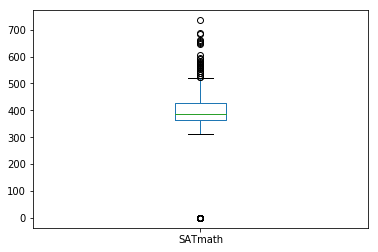

In [7]:
sat_2012_res['SATmath'].fillna(0).plot(kind = 'box')

#### Figure 1.1:
Figure showing box plot values of SAT mathematics. The outliers are indicated in circles showing a sizeable number of schools have a SAT math score greater than 1.5 times the inter quartile range.  

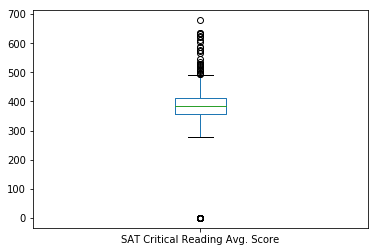

In [8]:
sat_2012_res['SAT Critical Reading Avg. Score'].fillna(0).plot(kind = 'box')

#### Figure 1.2:
Figure showing box plot values of average SAT reading score. The outliers are indicated in circles showing a sizeable number of schools have a average SAT reading score greater than 1.5 times the inter quartile range.  

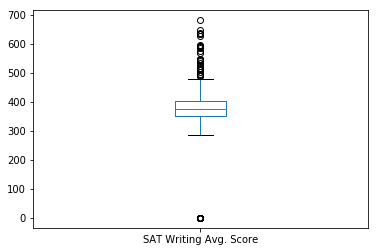

In [9]:
sat_2012_res['SAT Writing Avg. Score'].fillna(0).plot(kind = 'box')

#### Figure 1.3:
Figure showing box plot values of average SAT writing score. The outliers are indicated in circles showing a sizeable number of schools have a SAT writing score greater than 1.5 times the inter quartile range.  

In [10]:
# missing values are filled with the median value of the SAT scores due to the presence of high value outliers which might skew the overall mean 


sat_2012_res['SATmath'].fillna(sat_2012_res['SATmath'].median(),inplace=True)
sat_2012_res['SAT Critical Reading Avg. Score'].fillna(sat_2012_res['SAT Critical Reading Avg. Score'].median(),inplace=True)
sat_2012_res['SAT Writing Avg. Score'].fillna(sat_2012_res['SAT Writing Avg. Score'].median(),inplace=True)

In [11]:
sat_2012_res['SATall'] = ( sat_2012_res['SATmath']   + \
                      sat_2012_res['SAT Critical Reading Avg. Score']  + \
                     sat_2012_res['SAT Writing Avg. Score']) / 3
                         

In [12]:
sat_2012_res_reqd = sat_2012_res[['DBN' , 'SATmath' ,'SATall' ]]

In [13]:
sat_2012_res_reqd.head()

,DBN,SATmath,SATall
0,01M292,404.0,374.000000
1,01M448,423.0,390.666667
2,01M450,402.0,383.000000
3,01M458,401.0,391.333333
4,01M509,433.0,402.333333


### 1.2 Collect School Crime data 

In [17]:
nyc_school_crime_data = pd.read_csv( 'https://data.cityofnewyork.us/api/views/qybk-bjjc/rows.csv?accessType=DOWNLOAD')

In [18]:
# drop rows with null DBNS
nyc_school_crime_data.dropna(subset = ['DBN'], inplace = True)


### Inspect the distributions of crimes per school

#### Approach:
* Grouped schools by DBN. There are multiple schools in a given DBN.
* Obtained the mean crime statistics of each DBN using groupby (total crimes in each DBN / total schools in each DBN)
* Sum the different categories of crimes to obtain total crimes/school.
* Plot the resultant distributions for total crime type.


In [19]:
nyc_school_crime_data.columns

Index(['School Year', 'Building Code', 'DBN', 'Location Name', 'Location Code',
       'Address', 'Borough', 'Geographical District Code', 'Register',
       'Building Name', '# Schools', 'Schools in Building', 'Major N', 'Oth N',
       'NoCrim N', 'Prop N', 'Vio N', 'ENGroupA', 'RangeA', 'AvgOfMajor N',
       'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N',
       'Borough Name', 'Postcode', 'Latitude', 'Longitude', 'Community Board',
       'Council District ', 'Census Tract', 'BIN', 'BBL', 'NTA'],
      dtype='object')

In [20]:
nyc_school_crime_data = nyc_school_crime_data[['DBN', 'Longitude' ,'Latitude' , 'Major N' ,\
                                               'Oth N' , 'Prop N' ,'NoCrim N' , 'Vio N' , \
                                               'AvgOfMajor N' , 'AvgOfOth N' ,'AvgOfProp N' \
                                               , 'AvgOfNoCrim N' , 'AvgOfVio N']]

nyc_school_crime_data_final = nyc_school_crime_data[['DBN', 'Longitude' ,'Latitude' , 'Major N' ,\
                                               'Oth N' , 'Prop N' ,'NoCrim N' , 'Vio N' , \
                                               'AvgOfMajor N' , 'AvgOfOth N' ,'AvgOfProp N' \
                                               , 'AvgOfNoCrim N' , 'AvgOfVio N']]

In [21]:
# sum the total number of crimininal incidents occuring in each school, ie LOCATION NAME

nyc_crime_dbn_mean = nyc_school_crime_data[['DBN' , 'Major N' ,'Oth N' , 'Prop N' ,'NoCrim N' , 'Vio N',\
                                           'AvgOfMajor N' , 'AvgOfOth N' ,'AvgOfProp N'\
                                       , 'AvgOfNoCrim N' , 'AvgOfVio N' ]].groupby('DBN').mean()

In [22]:
nyc_crime_dbn_mean.head()

,Major N,Oth N,Prop N,NoCrim N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfProp N,AvgOfNoCrim N,AvgOfVio N
DBN,,,,,,,,,,
01M015,0.666667,0.666667,1.000000,0.666667,0.333333,0.343333,0.833333,0.713333,1.370000,0.366667
01M019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01M020,0.666667,2.000000,1.333333,3.000000,1.333333,0.306667,1.183333,0.790000,1.773333,0.543333
01M034,0.000000,1.333333,0.333333,1.333333,1.000000,0.296667,1.023333,0.720000,1.380000,0.473333
01M063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:

nyc_crime_dbn_mean['Total CrimesperSchool'] =  nyc_crime_dbn_mean['Oth N'] + nyc_crime_dbn_mean['Prop N'] + \
nyc_crime_dbn_mean['Oth N'] + nyc_crime_dbn_mean['NoCrim N'] + nyc_crime_dbn_mean['Vio N']  


(0, 80)

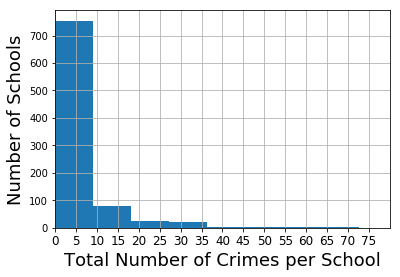

In [24]:
nyc_crime_dbn_mean['Total CrimesperSchool'].hist()
pl.ylabel("Number of Schools" ,fontsize=18.0);
pl.xlabel("Total Number of Crimes per School",fontsize=18.0);
xticks(np.arange(0, 80, step=5) , fontsize=12.)
pl.xlim(0,80)

#### Figure 2.1: 
Plot showing the distribution of the total crimes per school in a DBN. 
* Now most of the schools have < 10 incidents.
* Less than 100 schools have around 9 -18 incidents.
* The number of incidents > 18 progessively decreases in the number of schools.

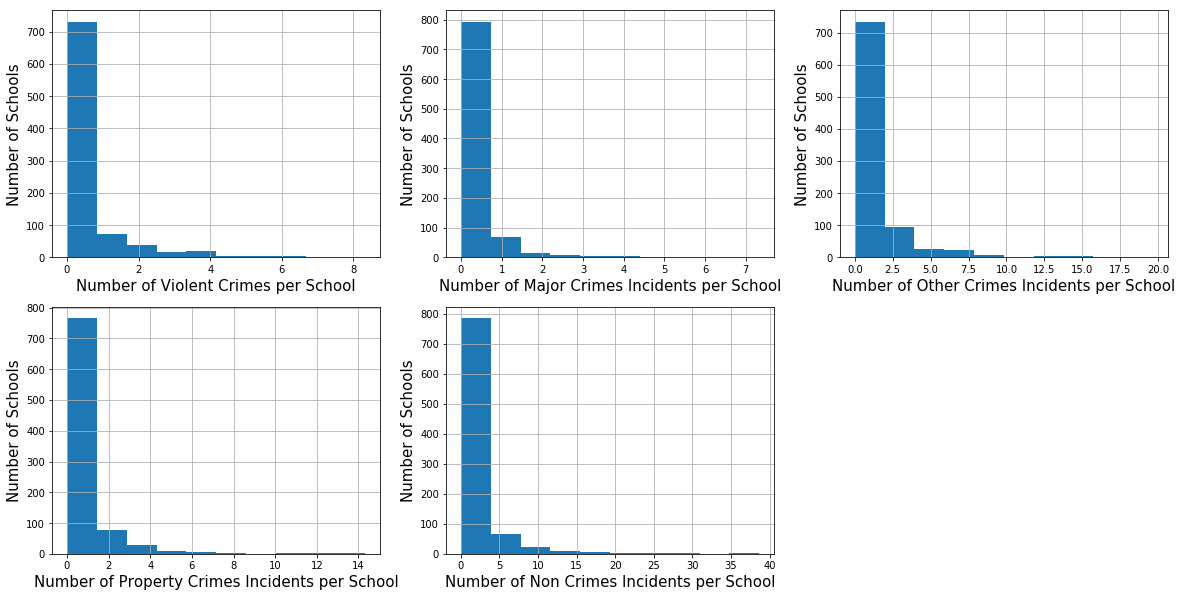

In [25]:
fig = pl.figure(figsize=(20,10))
ax1 = fig.add_subplot(231)
nyc_crime_dbn_mean['Vio N'].hist(ax=ax1)
pl.ylabel("Number of Schools",fontsize = 15);
pl.xlabel("Number of Violent Crimes per School",fontsize = 15);
#xticks(np.arange(0, 20, step=1))
#pl.xlim(0,20)


ax2 = fig.add_subplot(232)
nyc_crime_dbn_mean['Major N'].hist(ax=ax2)
pl.ylabel("Number of Schools",fontsize = 15);
pl.xlabel("Number of Major Crimes Incidents per School",fontsize = 15);
#xticks(np.arange(0, 20, step=1))
#pl.xlim(0,20)


ax3 = fig.add_subplot(233)
nyc_crime_dbn_mean['Oth N'].hist(ax=ax3)
pl.ylabel("Number of Schools" ,fontsize = 15);
pl.xlabel("Number of Other Crimes Incidents per School",fontsize = 15);
#xticks(np.arange(0, 60, step=3))
#pl.xlim(0,60)


ax4 = fig.add_subplot(234)
nyc_crime_dbn_mean['Prop N'].hist(ax=ax4)
pl.ylabel("Number of Schools",fontsize = 15);
pl.xlabel("Number of Property Crimes Incidents per School",fontsize = 15);
##xticks(np.arange(0, 30, step=3))
#pl.xlim(0,30)




ax6 = fig.add_subplot(235)
nyc_crime_dbn_mean['NoCrim N'].hist(ax=ax6)
pl.ylabel("Number of Schools",fontsize = 15);
pl.xlabel("Number of Non Crimes Incidents per School",fontsize = 15);
#xticks(np.arange(0, 20, step=1))
#pl.xlim(0,20)

#### Figure 2.2:
The above plots show the distribution of the crimes per school.
* A major of crime related incidents in school occur at a frequency at 1-2 in most schools
* Property and Other crimes in the range of 2-5 are higher in comparision to other crime related caegories.

### Plot the distribution of "Average number of Major" crimes by school


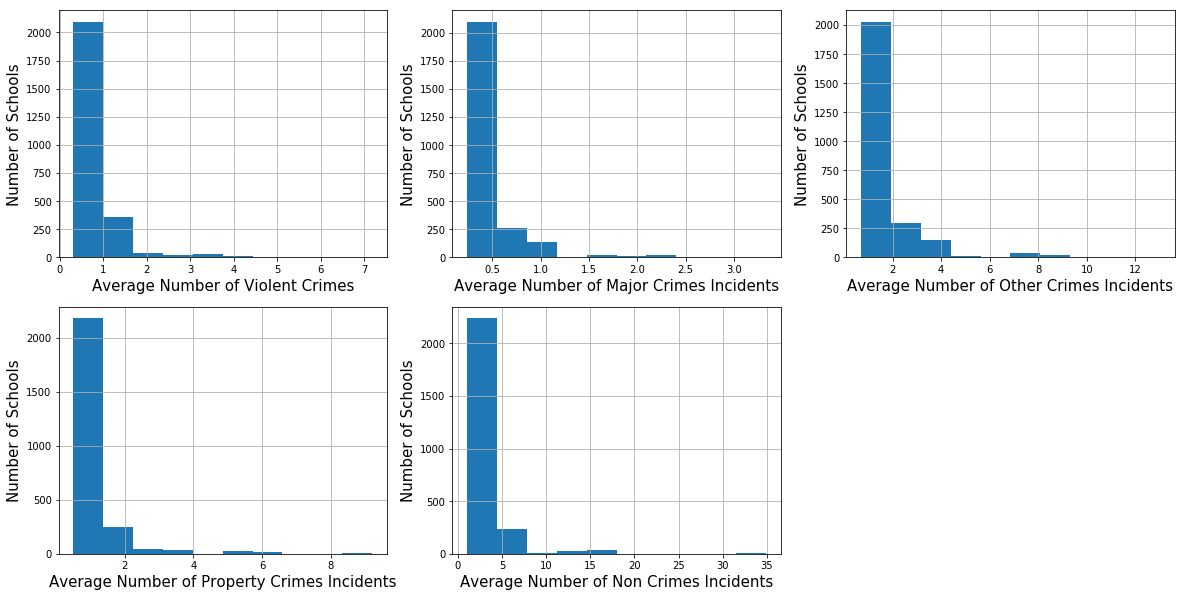

In [26]:
fig = pl.figure(figsize=(20,10))
ax1 = fig.add_subplot(231)
nyc_school_crime_data['AvgOfVio N'].hist(ax=ax1)
pl.ylabel("Number of Schools",fontsize = 15);
pl.xlabel("Average Number of Violent Crimes",fontsize = 15);
#xticks(np.arange(0, 20, step=1))
#pl.xlim(0,20)


ax2 = fig.add_subplot(232)
nyc_school_crime_data['AvgOfMajor N'].hist(ax=ax2)
pl.ylabel("Number of Schools",fontsize = 15);
pl.xlabel("Average Number of Major Crimes Incidents",fontsize = 15);
#xticks(np.arange(0, 20, step=1))
#pl.xlim(0,20)


ax3 = fig.add_subplot(233)
nyc_school_crime_data['AvgOfOth N'].hist(ax=ax3)
pl.ylabel("Number of Schools" ,fontsize = 15);
pl.xlabel("Average Number of Other Crimes Incidents",fontsize = 15);
#xticks(np.arange(0, 60, step=3))
#pl.xlim(0,60)


ax4 = fig.add_subplot(234)
nyc_school_crime_data['AvgOfProp N'].hist(ax=ax4)
pl.ylabel("Number of Schools",fontsize = 15);
pl.xlabel("Average Number of Property Crimes Incidents",fontsize = 15);
##xticks(np.arange(0, 30, step=3))
#pl.xlim(0,30)




ax6 = fig.add_subplot(235)
nyc_school_crime_data['AvgOfNoCrim N'].hist(ax=ax6)
pl.ylabel("Number of Schools",fontsize = 15);
pl.xlabel("Average Number of Non Crimes Incidents",fontsize = 15);
#xticks(np.arange(0, 20, step=1))
#pl.xlim(0,20)

#### Figure 2.3:
The above plots the distribution of the average number of incidents occuring in various schools.
* Property crimes and non crime incidents have the high frequency in the range (0-1) and (0-4) incidents respectively.
* On an average about 1 violent incident occurs in almost ~ 3000 schools
* The average figure is compartatively less (ie < 1) for the number of major incidents.


#### inspect the distribution of crimes per school

In [27]:
## School Location wise
isgaussian = sp.stats.kstest((nyc_crime_dbn_mean['Total CrimesperSchool'].dropna() - nyc_crime_dbn_mean['Total CrimesperSchool'].dropna().mean()) / nyc_crime_dbn_mean['Total CrimesperSchool'].dropna().std(), "norm")

isgaussian

KstestResult(statistic=0.27981921651727959, pvalue=0.0)

#### Interpretation:
A small value of the KS statistics indicates a small difference between the cumulative distributions that are being compared. 

# 2. Merge school crime and SAT data 

### Choice of Merging Variable:

When I merge the SAT table and the crime stats table using school name as index for both, I obtain only 33 values which I think is a small value and prohibitive for my analysis. So I will go with DBN as the choice of the merging  variable.

### 2.2 Fill in the missing data as appropriate keeping in mind that the school with no crimes are not included i the crime-in-school database, so there you can assume that there were 0 crimes, but the missing SAT scores cannot be assumed to be 0 of course

In [28]:
major_crime_0inc = nyc_school_crime_data[nyc_school_crime_data['Major N'] == 0].shape[0]
noncrim_crime_0inc = nyc_school_crime_data[nyc_school_crime_data['NoCrim N'] == 0].shape[0]
prop_crime_0inc = nyc_school_crime_data[nyc_school_crime_data['Prop N'] == 0].shape[0]
vio_crime_0inc = nyc_school_crime_data[nyc_school_crime_data['Vio N'] == 0].shape[0]
oth_crime_0inc = nyc_school_crime_data[nyc_school_crime_data['Oth N'] == 0].shape[0]

major_crime_1inc = nyc_school_crime_data[nyc_school_crime_data['Major N'] == 1].shape[0]
noncrim_crime_1inc = nyc_school_crime_data[nyc_school_crime_data['NoCrim N'] == 1].shape[0]
prop_crime_1inc = nyc_school_crime_data[nyc_school_crime_data['Prop N'] == 1].shape[0]
vio_crime_1inc = nyc_school_crime_data[nyc_school_crime_data['Vio N'] == 1].shape[0]
oth_crime_1inc = nyc_school_crime_data[nyc_school_crime_data['Oth N'] == 1].shape[0]




print('number of schools having 0 number of major crime incidents : ' + str(major_crime_0inc))
print('number of schools having 0 number of non crime incidents : ' + str(noncrim_crime_0inc))
print('number of schools having 0 number of property crime incidents : ' + str(prop_crime_0inc))
print('number of schools having 0 number of violent crime incidents : ' + str(vio_crime_0inc))
print('number of schools having 0 number of other crime incidents : ' + str(oth_crime_0inc))

print('number of schools having 1 number of major crime incidents : ' + str(major_crime_1inc))
print('number of schools having 1 number of non crime incidents : ' + str(noncrim_crime_1inc))
print('number of schools having 1 number of property crime incidents : ' + str(prop_crime_1inc))
print('number of schools having 1 number of violent crime incidents : ' + str(vio_crime_1inc))
print('number of schools having 1 number of other crime incidents : ' + str(oth_crime_1inc))

number of schools having 0 number of major crime incidents : 2044
number of schools having 0 number of non crime incidents : 1231
number of schools having 0 number of property crime incidents : 1520
number of schools having 0 number of violent crime incidents : 1923
number of schools having 0 number of other crime incidents : 1398
number of schools having 1 number of major crime incidents : 366
number of schools having 1 number of non crime incidents : 597
number of schools having 1 number of property crime incidents : 607
number of schools having 1 number of violent crime incidents : 352
number of schools having 1 number of other crime incidents : 569


Judging by the distributions, it seems that number of violent and major crimes are 0 for almost all schools. Therefore I am filling the nans of these columns with zeros.
Other crimes are more common. Therefore I am filling the nans of these columns with their respective meanvalues

In [29]:


nyc_school_crime_data_final['Oth N'].fillna(nyc_school_crime_data_final['Oth N'].mean() , inplace=True)
nyc_school_crime_data_final['NoCrim N'].fillna(nyc_school_crime_data_final['NoCrim N'].mean() , inplace=True)
nyc_school_crime_data_final['NoCrim N'].fillna(nyc_school_crime_data_final['NoCrim N'].mean() , inplace=True)
nyc_school_crime_data_final['Prop N'].fillna(nyc_school_crime_data_final['Prop N'].mean() , inplace=True)
nyc_school_crime_data_final['Vio N'].fillna(0 , inplace=True)
nyc_school_crime_data_final['Major N'].fillna(0 , inplace=True)

nyc_school_crime_data_final['AvgOfOth N'].fillna(nyc_school_crime_data_final['AvgOfOth N'].mean() , inplace=True)
nyc_school_crime_data_final['AvgOfNoCrim N'].fillna(nyc_school_crime_data_final['AvgOfNoCrim N'].mean() , inplace=True)
nyc_school_crime_data_final['AvgOfProp N'].fillna(nyc_school_crime_data_final['AvgOfProp N'].mean() , inplace=True)
nyc_school_crime_data_final['AvgOfVio N'].fillna(0 , inplace=True)
nyc_school_crime_data_final['AvgOfMajor N'].fillna(0 , inplace=True)

In [30]:
## PRE MERGE DATA FRAME SHAPE

nyc_school_crime_data_final.shape

(5308, 13)

## 2.1 Merge the SAT and the crime in school data based on the school identifier.

#### NOTE 1. : For the purpose of consistency , the variable DBN will be used to identify schools

#### NOTE 2. : After merge, drop_duplicates is perfromed to eliminate any duplicate rows removing redundancy

In [31]:
nyc_school_crime_data_final.head()

,DBN,Longitude,Latitude,Major N,Oth N,Prop N,NoCrim N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfProp N,AvgOfNoCrim N,AvgOfVio N
0,15K001,-74.012289,40.649042,0.0,2.000000,1.000000,1.000000,0.0,0.86,3.260000,2.170000,5.550000,1.29
1,17K002,-73.951583,40.656183,0.0,1.186792,0.808128,1.694021,0.0,0.00,1.698781,1.118339,2.726485,0.00
2,75K141,-73.951583,40.656183,0.0,1.186792,0.808128,1.694021,0.0,0.00,1.698781,1.118339,2.726485,0.00
3,84K704,-73.951583,40.656183,0.0,1.186792,0.808128,1.694021,0.0,0.00,1.698781,1.118339,2.726485,0.00
5,13K003,-73.955338,40.682663,2.0,0.000000,2.000000,0.000000,0.0,0.33,1.320000,0.830000,1.760000,0.59


In [32]:
sat_crime_data = pd.merge(nyc_school_crime_data_final, sat_2012_res_reqd ,left_on='DBN' , right_on='DBN').drop_duplicates()


In [33]:
## POST MERGE DATAFRAME SHAPE

sat_crime_data.shape

(725, 15)

### Post Merge comments:
* The dataset has reduced from about 5000 to 725

In [34]:
sat_crime_data.head()

,DBN,Longitude,Latitude,Major N,Oth N,Prop N,NoCrim N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfProp N,AvgOfNoCrim N,AvgOfVio N,SATmath,SATall
0,16K393,-73.931731,40.692126,0.0,1.186792,0.808128,1.694021,0.0,0.00,1.698781,1.118339,2.726485,0.00,355.0,356.0
3,02M418,-74.011556,40.704487,0.0,0.000000,0.000000,0.000000,0.0,0.33,1.320000,0.830000,1.760000,0.59,553.0,538.0
4,02M418,-74.011556,40.704487,0.0,0.000000,0.000000,0.000000,0.0,0.31,1.120000,0.790000,1.820000,0.51,553.0,538.0
5,02M418,-74.011556,40.704487,0.0,0.000000,0.000000,0.000000,0.0,0.28,1.110000,0.750000,1.740000,0.53,553.0,538.0
6,14K322,-73.946641,40.697152,0.0,1.186792,0.808128,1.694021,0.0,0.00,1.698781,1.118339,2.726485,0.00,395.0,389.0


In [35]:
#nyc_school_crime_data.reset_index(inplace = True)

latlong_count = nyc_school_crime_data[[ 'DBN' , 'Longitude' ,'Latitude']].groupby(['Longitude' ,'Latitude']).count()
latlong_count.head()

,,DBN
Longitude,Latitude,
-74.244118,40.509037,3
-74.243428,40.508284,3
-74.231109,40.510735,3
-74.222403,40.508809,6
-74.214002,40.542246,3


### Implication of Presence of multiple schools in the same building :

It may cause values to be skewed if aggegated at DBN (ie District Borough Number) , an identifier used by NYC Department of Education to identify schools belonging to the same building. If one school has higher crime count than other schools in the vicinity, the average values of the schools which will have the same DBN will thus get affected, resulting in an incorrect analysis

# 3. Visualize the school related data 

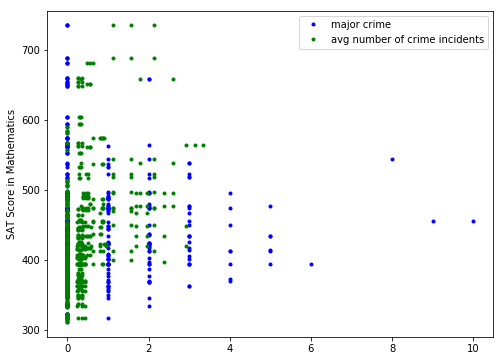

In [44]:
fig, ax = pl.subplots(figsize = (8,6))

ax.plot(sat_crime_data['Major N'] , sat_crime_data['SATmath'] , 'b.' ,label='major crime')
ax.plot(sat_crime_data['AvgOfMajor N'] , sat_crime_data['SATmath'] , 'g.' , label='avg number of crime incidents')

#pl.xlabel('Number of Major Incidents in DBN', fontsize=10)

pl.ylabel('SAT Score in Mathematics', fontsize=10)
pl.legend()

#### Figure 3.1:
The above graph dispays the scatterplot of :
1. SAT Score in Mathematics against number of major crimes
2. SAT Score in Mathematics against average number of crime incidents. 

Schools with 0 incidents(major and average) have the widest range of SAT scores.
As the number of incidents increases, most of the values tends to cluster in the lower end of 600 and below.

The schools having more than 7 incidents have less than 600 as the SAT Score in mathematics.

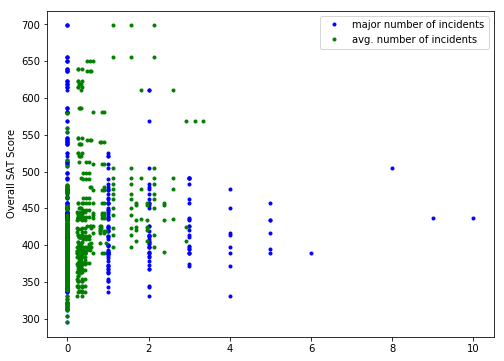

In [49]:
fig, ax = pl.subplots(figsize = (8,6))
ax.plot(sat_crime_data['Major N'] , sat_crime_data['SATall'] , 'b.' , label = 'major number of incidents')
ax.plot(sat_crime_data['AvgOfMajor N'] , sat_crime_data['SATall'] , 'g.' , label = 'avg. number of incidents')

#pl.xlabel('Number of Major Incidents in DBN', fontsize=10)
pl.ylabel('Overall SAT Score', fontsize=10)
pl.legend()

#### Figure 3.2:
The above graph dispays the scatterplot of :
1. Overall SAT score against number of major crimes
2. Overall SAT score against average number of crime incidents. 

Schools with 0 incidents(major and average) have the widest range of SAT scores.
As the number of incidents increases, most of the values tends to cluster in the lower end of 600 and below.

The schools having more than 7 incidents have less than 600 as the SAT Overall score.

## 3.2 create geometry from the lat-lon coordinates and map the location of each school in the dataset 

## 5.1 getting PUMA geodata

In [40]:
puma_url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"
urllib.request.urlretrieve(puma_url, "puma.zip")
!unzip -d $PUIDATA/puma_Finalpui/ puma.zip


Archive:  puma.zip
  inflating: /nfshome/vvt221/PUIdata/puma_Finalpui/geo_export_2c0fdeb7-cb3a-4d3e-a842-f23c8eb801c8.dbf  
  inflating: /nfshome/vvt221/PUIdata/puma_Finalpui/geo_export_2c0fdeb7-cb3a-4d3e-a842-f23c8eb801c8.shp  
  inflating: /nfshome/vvt221/PUIdata/puma_Finalpui/geo_export_2c0fdeb7-cb3a-4d3e-a842-f23c8eb801c8.shx  
  inflating: /nfshome/vvt221/PUIdata/puma_Finalpui/geo_export_2c0fdeb7-cb3a-4d3e-a842-f23c8eb801c8.prj  


In [99]:
puma_file = glob.glob(os.getenv('PUIDATA') + '/puma_Finalpui/*.shp') 
puma = gp.GeoDataFrame.from_file(puma_file[0])

In [100]:
puma.crs

{'init': 'epsg:4326'}

In [101]:
sat_crime_data['lonlat'] = list(zip(sat_crime_data.Longitude , sat_crime_data.Latitude))
sat_crime_data['geometry'] = sat_crime_data[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
sat_crime_data.head()

,DBN,Longitude,Latitude,Major N,Oth N,Prop N,NoCrim N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfProp N,AvgOfNoCrim N,AvgOfVio N,SATmath,SATall,lonlat,geometry
0,16K393,-73.931731,40.692126,0.0,1.186792,0.808128,1.694021,0.0,0.00,1.698781,1.118339,2.726485,0.00,355.0,356.0,"(-73.931731, 40.692126)",POINT (-73.931731 40.692126)
3,02M418,-74.011556,40.704487,0.0,0.000000,0.000000,0.000000,0.0,0.33,1.320000,0.830000,1.760000,0.59,553.0,538.0,"(-74.011556, 40.704487)",POINT (-74.011556 40.704487)
4,02M418,-74.011556,40.704487,0.0,0.000000,0.000000,0.000000,0.0,0.31,1.120000,0.790000,1.820000,0.51,553.0,538.0,"(-74.011556, 40.704487)",POINT (-74.011556 40.704487)
5,02M418,-74.011556,40.704487,0.0,0.000000,0.000000,0.000000,0.0,0.28,1.110000,0.750000,1.740000,0.53,553.0,538.0,"(-74.011556, 40.704487)",POINT (-74.011556 40.704487)
6,14K322,-73.946641,40.697152,0.0,1.186792,0.808128,1.694021,0.0,0.00,1.698781,1.118339,2.726485,0.00,395.0,389.0,"(-73.946641, 40.697152)",POINT (-73.946641 40.697152)


In [102]:
crs = {'init': 'epsg:4326'}

school_crime_gdf = gp.GeoDataFrame(sat_crime_data, crs=crs)


In [103]:
crs = {'init': 'epsg:2263'}
puma_convert = gp.GeoDataFrame(puma, crs=crs)

In [104]:
crs = {'init': 'epsg:2263'}
school_crime_convert = gp.GeoDataFrame(school_crime_gdf, crs=crs)

In [105]:
school_puma = gp.sjoin(puma_convert ,school_crime_convert )

In [106]:
school_puma.head()

,puma,shape_area,shape_leng,geometry,index_right,DBN,Longitude,Latitude,Major N,Oth N,...,NoCrim N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfProp N,AvgOfNoCrim N,AvgOfVio N,SATmath,SATall,lonlat
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,1200,10X342,-73.898309,40.870293,0.0,1.186792,...,1.694021,0.0,0.0,1.698781,1.118339,2.726485,0.0,333.0,311.333333,"(-73.898309, 40.870293)"
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,1197,10X268,-73.898309,40.870293,0.0,1.186792,...,1.694021,0.0,0.0,1.698781,1.118339,2.726485,0.0,356.0,320.666667,"(-73.898309, 40.870293)"
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,1160,10X549,-73.898309,40.870293,0.0,1.186792,...,1.694021,0.0,0.0,1.698781,1.118339,2.726485,0.0,379.0,371.666667,"(-73.898309, 40.870293)"
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,1203,10X433,-73.898309,40.870293,0.0,1.186792,...,1.694021,0.0,0.0,1.698781,1.118339,2.726485,0.0,371.0,368.666667,"(-73.898309, 40.870293)"
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,1206,10X442,-73.898309,40.870293,0.0,1.186792,...,1.694021,0.0,0.0,1.698781,1.118339,2.726485,0.0,420.0,423.333333,"(-73.898309, 40.870293)"


### Approach:
School SAT scores and crime statistics  data is merged by grouping with the puma and then taking the mean values

In [107]:
school_puma_data = school_puma[['Major N',
       'Oth N', 'NoCrim N', 'Prop N', 'Vio N', 'AvgOfMajor N', 'AvgOfOth N',
       'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N','SATall', 'SATmath' , 'puma']].groupby('puma').mean()

In [108]:
school_puma_data.head()

,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATall,SATmath
puma,,,,,,,,,,,,
3701,0.052632,1.858292,3.571481,1.087205,0.263158,0.501579,2.921130,4.902389,1.825704,0.945263,473.824561,488.157895
3702,0.000000,1.186792,1.694021,0.808128,0.000000,0.000000,1.698781,2.726485,1.118339,0.000000,374.740741,378.555556
3703,0.000000,1.186792,1.694021,0.808128,0.000000,0.000000,1.698781,2.726485,1.118339,0.000000,391.400000,394.400000
3704,0.250000,2.926729,3.097011,1.654064,1.166667,0.153333,1.380224,2.120743,0.949169,0.236667,402.416667,410.166667
3705,0.400000,2.677735,4.206712,1.344470,1.000000,0.139750,1.423330,2.236067,0.956586,0.223750,373.791667,378.875000


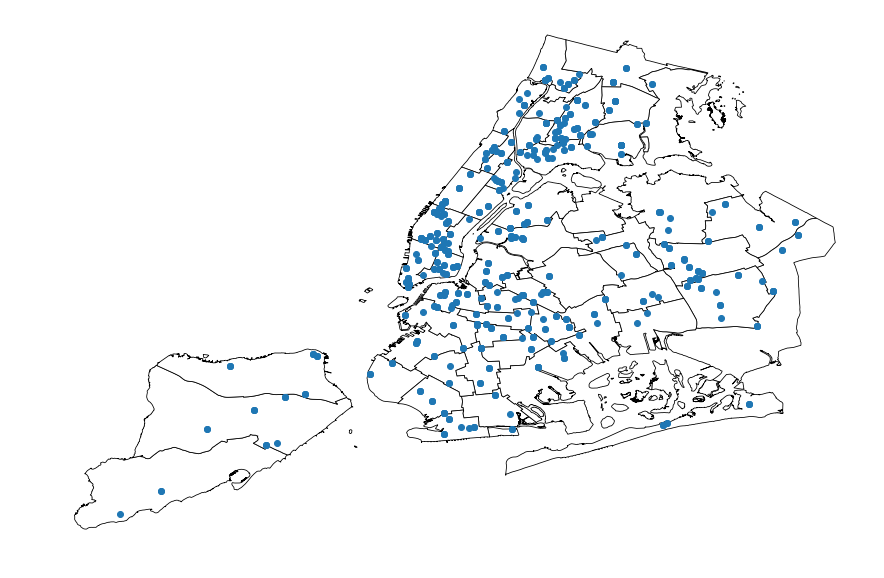

In [109]:
fig, ax = plt.subplots(1, figsize=(15,10))

puma.plot(linewidth=0.8, ax=ax, edgecolor='black' , color='white')
ax.axis('off')

school_crime_gdf.plot(ax=ax)

#### Figure 3.3:
Plot showing the location of schools on the PUMAs of New York City. The schools are distributed across the all the PUMAS. Therefore we can capture information about almost all the PUMAs

# 4 Gather Asthma and drugs hospital discharge

## 4.1 read in the SPARCS data

In [52]:
hospital_data_url = 'https://health.data.ny.gov/download/3m9u-ws8e/application%2Fzip'
urllib.request.urlretrieve(hospital_data_url, "hospital_data.zip")
!unzip -d $PUIDATA/hd7/ hospital_data.zip


Archive:  hospital_data.zip
  inflating: /nfshome/vvt221/PUIdata/hd7/NYSDOH_HospitalInpatientDischarges_SPARCS_De-Identified_2012.csv  
  inflating: /nfshome/vvt221/PUIdata/hd7/NYSDOH_SPARCS_De-Identified_2012_DataDictionary.pdf  
  inflating: /nfshome/vvt221/PUIdata/hd7/NYSDOH_SPARCS_De-Identified_2012_Overview.pdf  


In [50]:
hospital_dat = pd.read_csv( os.getenv('PUIDATA') + '/hd7/NYSDOH_HospitalInpatientDischarges_SPARCS_De-Identified_2012.csv')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [51]:
hospital_dat.columns

Index(['Hospital Service Area', 'Hospital County',
       'Operating Certificate Number', 'Permanent Facility Id',
       'Facility Name', 'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race',
       'Ethnicity', 'Length of Stay', 'Type of Admission',
       'Patient Disposition', 'Discharge Year', 'CCS Diagnosis Code',
       'CCS Diagnosis Description', 'CCS Procedure Code',
       'CCS Procedure Description', 'APR DRG Code', 'APR DRG Description',
       'APR MDC Code', 'APR MDC Description', 'APR Severity of Illness Code',
       'APR Severity of Illness Description', 'APR Risk of Mortality',
       'APR Medical Surgical Description', 'Payment Typology 1',
       'Payment Typology 2', 'Payment Typology 3',
       'Attending Provider License Number',
       'Operating Provider License Number', 'Other Provider License Number',
       'Birth Weight', 'Abortion Edit Indicator',
       'Emergency Department Indicator', 'Total Charges', 'Total Costs',
       'Ratio of Total Costs to Tota

In [52]:
hospital_dat.dtypes

Hospital Service Area                     object
Hospital County                           object
Operating Certificate Number             float64
Permanent Facility Id                    float64
Facility Name                             object
Age Group                                 object
Zip Code - 3 digits                       object
Gender                                    object
Race                                      object
Ethnicity                                 object
Length of Stay                            object
Type of Admission                         object
Patient Disposition                       object
Discharge Year                             int64
CCS Diagnosis Code                         int64
CCS Diagnosis Description                 object
CCS Procedure Code                         int64
CCS Procedure Description                 object
APR DRG Code                               int64
APR DRG Description                       object
APR MDC Code        

In [53]:
hospital_dat['Hospital County'].unique()

array(['Allegany', nan, 'Cattaraugus', 'Chautauqua', 'Erie', 'Genesee',
       'Niagara', 'Orleans', 'Wyoming', 'Chemung', 'Livingston', 'Monroe',
       'Ontario', 'Schuyler', 'Steuben', 'Wayne', 'Yates', 'Oswego',
       'Broome', 'Cayuga', 'Chenango', 'Cortland', 'Herkimer', 'Jefferson',
       'Lewis', 'Madison', 'Oneida', 'Onondaga', 'St Lawrence', 'Tompkins',
       'Albany', 'Clinton', 'Columbia', 'Delaware', 'Essex', 'Franklin',
       'Fulton', 'Montgomery', 'Otsego', 'Rensselaer', 'Saratoga',
       'Schenectady', 'Schoharie', 'Warren', 'Dutchess', 'Orange',
       'Putnam', 'Rockland', 'Sullivan', 'Ulster', 'Westchester', 'Bronx',
       'Kings', 'Manhattan', 'Richmond', 'Queens', 'Suffolk', 'Nassau'], dtype=object)

## Calculate the fraction of asthma and drug related diagnoses per facility for the various boroughs in New York City

In [70]:
hospital_data_nyc = hospital_dat[ (hospital_dat['Hospital County'] == 'Queens') | \
                                (hospital_dat['Hospital County'] == 'Bronx') | \
                                (hospital_dat['Hospital County'] == 'Richmond') | \
                                (hospital_dat['Hospital County'] == 'Manhattan') | \
                                (hospital_dat['Hospital County'] == 'Kings')]

In [71]:
nd = hospital_data_nyc.shape[0]
print("number of NYC discharges", nd)


number of NYC discharges 1199520


In [72]:
nycF = hospital_data_nyc['Permanent Facility Id'].dropna().unique().shape[0]
print("number of NYC facilities in the dataset", nycF)

number of NYC facilities in the dataset 61


### Filter by diagnosistype:

#### Respiratory Issues
*  Asthma
*  Respiratory failure; insufficiency; arrest (adult)
*  Respiratory distress syndrome

#### Drug related issues
*  Poisoning by psychotropic agents
*  Alcohol-related disorders
*  Substance-related disorders

In [73]:


hospital_data_nyc_diag = hospital_data_nyc[(hospital_data_nyc['CCS Diagnosis Description'] == 'Asthma') | (hospital_data_nyc['CCS Diagnosis Description'] == 'Respiratory failure; insufficiency; arrest (adult)') |  \
(hospital_data_nyc['CCS Diagnosis Description'] == 'Arrest (adult)') | (hospital_data_nyc['CCS Diagnosis Description'] == 'Respiratory distress syndrome') | \
(hospital_data_nyc['CCS Diagnosis Description'] == 'Poisoning by psychotropic agents')  | (hospital_data_nyc['CCS Diagnosis Description'] == 'Alcohol-related disorders') | \
(hospital_data_nyc['CCS Diagnosis Description'] == 'Substance-related disorders') ]

In [74]:
hospital_data_nyc_diag['CCS Diagnosis Description'].unique()

array(['Alcohol-related disorders', 'Substance-related disorders',
       'Poisoning by psychotropic agents', 'Asthma',
       'Respiratory failure; insufficiency; arrest (adult)',
       'Respiratory distress syndrome'], dtype=object)

In [75]:
nyca = hospital_data_nyc_diag[(hospital_data_nyc_diag['CCS Diagnosis Description'] == 'Asthma') | \
                       (hospital_data_nyc_diag['CCS Diagnosis Description'] == 'Respiratory failure; insufficiency; arrest (adult)') | \
                       (hospital_data_nyc_diag['CCS Diagnosis Description'] == 'Respiratory distress syndrome') ].shape[0]
                       
print("number of asthma related cases in NYC", nyca) 

number of asthma related cases in NYC 30717


In [76]:
nycd = hospital_data_nyc_diag[ (hospital_data_nyc_diag['CCS Diagnosis Description'] == 'Poisoning by psychotropic agents')  | (hospital_data_nyc_diag['CCS Diagnosis Description'] == 'Alcohol-related disorders') | \
(hospital_data_nyc_diag['CCS Diagnosis Description'] == 'Substance-related disorders') ].shape[0]
print("number of drug related cases in NYC", nycd)

number of drug related cases in NYC 46336


In [77]:
hospital_data_nyc_diag = hospital_data_nyc_diag[['Permanent Facility Id' ,'CCS Diagnosis Description']]

In [78]:
hospital_data_nyc_diag_asthma = hospital_data_nyc_diag[(hospital_data_nyc_diag['CCS Diagnosis Description'] == 'Asthma') | \
                       (hospital_data_nyc_diag['CCS Diagnosis Description'] == 'Respiratory failure; insufficiency; arrest (adult)') | \
                       (hospital_data_nyc_diag['CCS Diagnosis Description'] == 'Respiratory distress syndrome') ]


hospital_data_nyc_diag_drug = hospital_data_nyc_diag[ (hospital_data_nyc_diag['CCS Diagnosis Description'] == 'Poisoning by psychotropic agents')  | (hospital_data_nyc_diag['CCS Diagnosis Description'] == 'Alcohol-related disorders') | \
(hospital_data_nyc_diag['CCS Diagnosis Description'] == 'Substance-related disorders') ]


In [79]:
asthma_count = hospital_data_nyc_diag_asthma.groupby('Permanent Facility Id').count()
asthma_count.rename(columns = { 'CCS Diagnosis Description' : 'asthma_case_count'} , inplace = True)

drug_count = hospital_data_nyc_diag_drug.groupby('Permanent Facility Id').count()
drug_count.rename(columns = { 'CCS Diagnosis Description' : 'drug_case_count'} , inplace = True) 

In [80]:
asthma_count.head()

,asthma_case_count
Permanent Facility Id,
1165.0,1123
1168.0,580
1169.0,2105
1172.0,1826
1175.0,25


In [81]:
asthma_drug_counts = pd.concat([ asthma_count , drug_count ] ,axis=1)
#asthma_drug_counts.fillna(0, inplace = True)

In [82]:
all_counts = hospital_data_nyc[['Permanent Facility Id' , 'CCS Diagnosis Description']].groupby('Permanent Facility Id').count()
all_counts.rename(columns = { 'CCS Diagnosis Description' : 'total_case_count'} , inplace = True)

In [83]:
total_tally = pd.concat([ asthma_drug_counts , all_counts ] ,axis=1)

In [84]:
total_tally.dropna(inplace = True)

In [85]:
total_tally.head()

,asthma_case_count,drug_case_count,total_case_count
Permanent Facility Id,,,
1165.0,1123.0,1279.0,20956
1168.0,580.0,1006.0,15889
1169.0,2105.0,323.0,43650
1172.0,1826.0,611.0,23142
1176.0,910.0,4177.0,20585


In [86]:
total_tally['asthmaRatio'] = total_tally['asthma_case_count'] / total_tally['total_case_count']
total_tally['drugsRatio'] = total_tally['drug_case_count'] / total_tally['total_case_count']

In [87]:
total_tally_ratio = total_tally.drop(['asthma_case_count', 'drug_case_count' ,'total_case_count'] , axis = 1)

In [88]:
total_tally_ratio.reset_index(inplace = True)
total_tally_ratio['Permanent Facility Id'] = total_tally_ratio['Permanent Facility Id'].astype(int)
total_tally_ratio.set_index('Permanent Facility Id' ,inplace = True)

In [89]:
total_tally_ratio.head()

,asthmaRatio,drugsRatio
Permanent Facility Id,,
1165,0.053588,0.061033
1168,0.036503,0.063314
1169,0.048225,0.007400
1172,0.078904,0.026402
1176,0.044207,0.202915


## Find the location of each facility 

In [90]:
API_URL = 'https://fb55.carto.com:443/api/v2/sql?q='
def queryCartoDB(query, formatting = 'CSV', source = API_URL):
    '''queries carto datasets from a given carto account
    Arguments: 
    query - string: a valid sql query string
    format - outlut format  OPTIONAL (default CSV)
    source - a valid sql api endpoint OPTIONAL (default carto fb55 account)
    Returns:
    the return of the sql query AS A STRING
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    
    
    data = urlencode({'format': formatting, 'q': query}).encode("utf-8")
    try:
        response = urlopen(source, data)
        return response.read()
    except HTTPError as e:
        raise (ValueError('\n'.join(ast.literal_eval(e.readline())['error'])))
        
def get_data(query):
    try:
        return pd.read_csv(io(queryCartoDB(query)), sep = ',')
    except ValueError as v:
        print (str(v))

In [91]:
query = '''select * from nyc_facilities;'''

hospital_data = get_data(query)

hospital_data.head(10)

,the_geom,regional_office,the_geom_webmercator,facility_id,facility_name,short_description,description,facility_open_date,facility_address_1,facility_address_2,...,cooperator_name,cooperator_address,cooperator_address_2,cooperator_city,cooperator_state,cooperator_zip_code,ownership_type,facility_latitude,facility_longitude,facility_location
0,0101000020E6100000E40F069E7B7C52C05952EE3EC753...,Metropolitan Area Regional Office - New York City,0101000020110F000046B5633099665FC167AF70FB3AED...,1320,University Hospital of Brooklyn,HOSP,Hospital,01/01/1901,445 Lenox Road,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,State,40.654518,-73.945045,"(40.654518, -73.945045)"
1,0101000020E61000008BC058DFC07852C04BC8073D9B53...,Metropolitan Area Regional Office - New York City,0101000020110F00001F2C777543605FC14E668BB709ED...,6448,PALA Community Care,DTC,Diagnostic and Treatment Center,09/12/2002,1110 Pennsylvania Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,LLC,40.653175,-73.886772,"(40.653175, -73.886772)"
2,0101000020E6100000D3DC0A61357D52C09AFF571D3958...,Metropolitan Area Regional Office - New York City,0101000020110F00006ACD5FB9D4675FC19AEE7C2435F2...,6754,Medcare LLC,DTC,Diagnostic and Treatment Center,02/26/2007,468 Lafayette Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,LLC,40.689243,-73.956383,"(40.689243, -73.956383)"
3,0101000020E61000006DCA15DEE57952C08A027D224F6C...,Metropolitan Area Regional Office - New York City,0101000020110F00007164F52335625FC110A7A85CBB08...,1206,P R O M E S A Inc,DTC,Diagnostic and Treatment Center,09/27/1979,1776 Clay Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.846165,-73.904655,"(40.846165, -73.904655)"
4,0101000020E6100000D6C4025FD17A52C038BF61A24168...,Metropolitan Area Regional Office - New York City,0101000020110F00006301C42AC5635FC1A351F0D12E04...,1207,Narco Freedom Inc,DTC,Diagnostic and Treatment Center,09/27/1979,479 Willis Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.814503,-73.919029,"(40.814503, -73.919029)"
5,0101000020E6100000C02500FF947952C0ED9925016A6A...,Metropolitan Area Regional Office - New York City,0101000020110F000027A7AFC5AB615FC19CB32DC29A06...,9580,Monroe Academy Campus,NaN,School Based Diagnostic and Treatment Center E...,09/25/2012,1300 Boyton Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.831360,-73.899719,"(40.83136, -73.899719)"
6,0101000020E6100000D9D0CDFE407052C030F65E7CD14C...,Metropolitan Area Regional Office - New York City,0101000020110F00002E253A83D3515FC175195D2371E5...,9509,Rockaway Dialysis,DTC,Diagnostic and Treatment Center,01/11/2013,529 Beach 20 Street,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,LLC,40.600143,-73.753967,"(40.600143, -73.753967)"
7,0101000020E6100000E527D53E1D7C52C0F86C1D1CEC5F...,Metropolitan Area Regional Office - New York City,0101000020110F0000BA8892E3F8655FC18D3BA9CAD5FA...,286,New York City Department of Health and Mental ...,DTC,Diagnostic and Treatment Center,04/10/1980,42-09 28th Street,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,Municipality,40.749393,-73.939285,"(40.749393, -73.939285)"
8,0101000020E6100000271422E0107652C0973B33C1706C...,Metropolitan Area Regional Office - New York City,0101000020110F0000E67AABD3B25B5FC1EEF8A31BE108...,9652,Waters Place Dialysis Center,DTC-EC,Diagnostic and Treatment Center Extension Clinic,03/21/2014,1733 Eastchester Road,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,Business Corporation,40.847191,-73.844780,"(40.847191, -73.84478)"
9,0101000020E610000045EC1340317C52C0B1BFEC9E3C68...,Metropolitan Area Regional Office - New York City,0101000020110F0000D4CE85DE1A665FC15D23AB312904...,1445,Harlem Hospital Center,HOSP,Hospital,01/01/1901,506 Lenox Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,Municipality,40.814350,-73.940506,"(40.81435, -73.940506)"


In [92]:
hospital_data.set_index('facility_id' , inplace = True)

In [93]:
hostipal_locn_data = pd.merge( hospital_data , total_tally_ratio , left_index = True , right_index = True)

In [94]:
print('Pre Merge')
print('Number of Facility location Dataframe Rows' + str(hospital_data.shape[0]))
print('total_tally_ratio Dataframe Rows' + str(hospital_data.shape[0]))


print('Post Merge')
print('Post Merge Number of Rows' + str(hostipal_locn_data.shape[0]))


Pre Merge
Number of Facility location Dataframe Rows1275
total_tally_ratio Dataframe Rows1275
Post Merge
Post Merge Number of Rows49


# 5. Aggregate at the PUMA level 

In [95]:
hostipal_locn_data_gdf = gp.GeoDataFrame(hostipal_locn_data)


In [96]:
hostipal_locn_data_gdf['lonlat'] = list(zip(hostipal_locn_data_gdf.facility_longitude , hostipal_locn_data_gdf.facility_latitude))
hostipal_locn_data_gdf['geometry'] = hostipal_locn_data_gdf[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
#school_crime.head()

In [97]:
hostipal_locn_data_gdf.crs = from_epsg(4326)


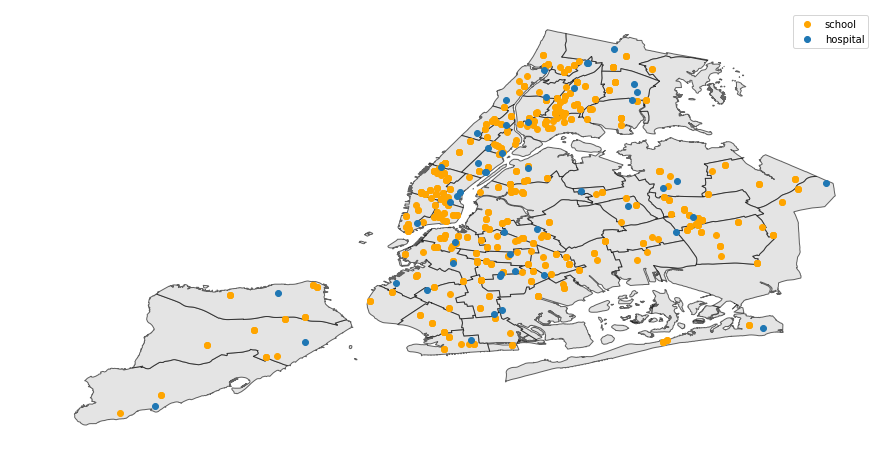

In [110]:
fig, ax = pl.subplots(1, figsize=(15,8))

puma.plot(linewidth=1.0, ax=ax, edgecolor='black' , color='lightgrey' ,alpha=0.6)
ax.axis('off')

school_crime_gdf.plot(ax=ax , color='orange' , legend=True , label='school' )

hostipal_locn_data_gdf.plot(ax=ax ,legend=True , label='hospital')

pl.legend()

#### Figure 5.1:
Plot showing the location of various schools and hospitals in NYC. Most of the schools have atleast 1 hospital in its vicinity. This is not the case for some schools in Staten Island. It is also observed in the south eastern part of the city.

## 5.2 join hospital facilities and PUMA data

In [111]:
hostipal_locn_data_gdf.reset_index(inplace = True)

In [112]:
hostipal_locn_data_gdf = hostipal_locn_data_gdf[['asthmaRatio', 'drugsRatio', 'geometry']]

In [113]:
crs = {'init': 'epsg:2263'}
hostipal_locn_data_gdf_convert = gp.GeoDataFrame(hostipal_locn_data_gdf, crs=crs)

In [114]:
hospital_puma = gp.sjoin(puma_convert ,hostipal_locn_data_gdf_convert )

In [115]:
puma_convert.set_index('puma' ,inplace = True)

### Approach:
Hospital Facility data is merged by grouping with the puma and then taking the mean values

In [116]:
hospital_puma_mean = hospital_puma[[ 'asthmaRatio' , 'drugsRatio' , 'puma']].groupby(['puma']).mean()

In [117]:
hospital_puma_mean = puma_convert.merge(hospital_puma_mean, left_index = True , right_index = True)

In [118]:
hospital_puma_mean.head()

,shape_area,shape_leng,geometry,asthmaRatio,drugsRatio
puma,,,,,
3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",0.036503,0.063314
3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",0.037053,0.032269
3705,1.224951e+08,68657.316149,POLYGON ((-73.87359713633828 40.83979855593596...,0.044207,0.202915
3706,4.388687e+07,51799.404183,"POLYGON ((-73.88785196328796 40.8721141761279,...",0.038256,0.013680
3707,4.228113e+07,37347.925798,"POLYGON ((-73.89735765412577 40.8587627349268,...",0.054454,0.013583


In [119]:
hospital_puma_mean.dtypes

shape_area     float64
shape_leng     float64
geometry        object
asthmaRatio    float64
drugsRatio     float64
dtype: object

## Join school data and puma

In [120]:
hopital_school_puma_data = hospital_puma_mean.merge(school_puma_data , left_index = True , right_index = True).reset_index()

In [121]:
hopital_school_puma_data.columns

Index(['puma', 'shape_area', 'shape_leng', 'geometry', 'asthmaRatio',
       'drugsRatio', 'Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N',
       'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N', 'SATall', 'SATmath'],
      dtype='object')

In [122]:
alldata = hopital_school_puma_data[['puma', 'Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N',
       'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N',
       'AvgOfVio N','asthmaRatio',
       'drugsRatio', 'SATmath' , 'SATall']]

In [123]:
alldata.head()

,puma,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,asthmaRatio,drugsRatio,SATmath,SATall
0,3702,0.00,1.186792,1.694021,0.808128,0.000000,0.000000,1.698781,2.726485,1.118339,0.000000,0.036503,0.063314,378.555556,374.740741
1,3704,0.25,2.926729,3.097011,1.654064,1.166667,0.153333,1.380224,2.120743,0.949169,0.236667,0.037053,0.032269,410.166667,402.416667
2,3705,0.40,2.677735,4.206712,1.344470,1.000000,0.139750,1.423330,2.236067,0.956586,0.223750,0.044207,0.202915,378.875000,373.791667
3,3707,0.00,1.186792,1.694021,0.808128,0.000000,0.000000,1.698781,2.726485,1.118339,0.000000,0.054454,0.013583,365.000000,356.833333
4,3709,0.00,1.186792,1.694021,0.808128,0.000000,0.000000,1.698781,2.726485,1.118339,0.000000,0.057007,0.003671,380.631579,373.280702


In [124]:
alldata.shape

(36, 15)

In [125]:
independent_params = alldata.drop('puma',axis=1)

In [126]:
independent_params.corr()

,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,asthmaRatio,drugsRatio,SATmath,SATall
Major N,1.000000,0.771857,0.674307,0.796185,0.866153,0.539346,0.354033,0.338430,0.361599,0.535118,-0.070378,0.044632,0.387081,0.422904
Oth N,0.771857,1.000000,0.937968,0.953956,0.895332,0.742092,0.617927,0.603086,0.625780,0.748800,-0.036870,-0.124160,0.471028,0.500166
NoCrim N,0.674307,0.937968,1.000000,0.856814,0.841867,0.691454,0.577273,0.566541,0.583935,0.702740,-0.079150,-0.149145,0.459593,0.502029
Prop N,0.796185,0.953956,0.856814,1.000000,0.793420,0.726726,0.620090,0.609633,0.628087,0.733668,-0.079792,-0.098994,0.457888,0.483099
Vio N,0.866153,0.895332,0.841867,0.793420,1.000000,0.617435,0.419258,0.404734,0.428383,0.614216,-0.012818,-0.069469,0.380194,0.420568
AvgOfMajor N,0.539346,0.742092,0.691454,0.726726,0.617435,1.000000,0.910852,0.921803,0.908416,0.998075,-0.245063,-0.256694,0.664251,0.696005
AvgOfOth N,0.354033,0.617927,0.577273,0.620090,0.419258,0.910852,1.000000,0.984701,0.998735,0.923980,-0.219378,-0.256021,0.607241,0.612523
AvgOfNoCrim N,0.338430,0.603086,0.566541,0.609633,0.404734,0.921803,0.984701,1.000000,0.978229,0.934726,-0.220637,-0.246196,0.597446,0.609220
AvgOfProp N,0.361599,0.625780,0.583935,0.628087,0.428383,0.908416,0.998735,0.978229,1.000000,0.920302,-0.218586,-0.259126,0.601392,0.607765
AvgOfVio N,0.535118,0.748800,0.702740,0.733668,0.614216,0.998075,0.923980,0.934726,0.920302,1.000000,-0.240502,-0.249695,0.666504,0.694313


In [127]:
independent_params_std = (independent_params - independent_params.mean()) / independent_params.std()

In [107]:
independent_params_std_sans_medical = independent_params_std.drop(['asthmaRatio','drugsRatio'],axis = 1)

# Plot a covariance matrix of all features

[Text(0,0,'Major N'),
 Text(0,0,'Oth N'),
 Text(0,0,'NoCrim N'),
 Text(0,0,'Prop N'),
 Text(0,0,'Vio N'),
 Text(0,0,'AvgOfMajor N'),
 Text(0,0,'AvgOfOth N'),
 Text(0,0,'AvgOfNoCrim N'),
 Text(0,0,'AvgOfProp N'),
 Text(0,0,'AvgOfVio N'),
 Text(0,0,'asthmaRatio'),
 Text(0,0,'drugsRatio'),
 Text(0,0,'SATmath'),
 Text(0,0,'SATall')]

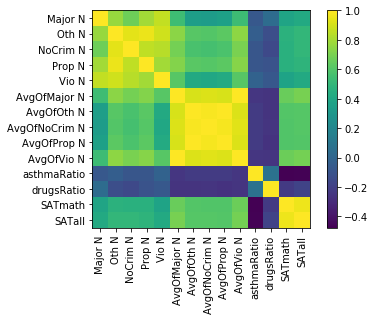

In [109]:
ax = pl.figure().add_subplot(111)
cax = ax.imshow(independent_params.corr())
pl.colorbar(cax)
ax.set_xticks(range(len(independent_params_std.columns)))
ax.set_xticklabels(independent_params.columns, rotation=90)
ax.set_yticks(range(len(independent_params.columns)))
ax.set_yticklabels(independent_params.columns)

#### Figure :

* The heat map cleary shows correlation between related variables.
* The SATmath score is an easy determiner of the overall SAT score( Also , true for the converse)
* All the crime related statics show correlation with each other.
* The average crime statistics show highest correlation with each other.


* The crime statistics show a mild positive correlation to SAT scores.
* The asthmaratio and the drugratio show high negative correlation with the SAT scores.
* The asthmaratio and the drugratio show high negative correlation with the crime statistics too.


* The asthmaratio does not correlate with the drugratio

# Add income data:

In [110]:
puma_income_url = 'https://data.cityofnewyork.us/api/views/8fje-7v4x/files/2a7e053b-2ebf-43d5-be55-e42e8754c7c8?filename=ACS5yrPUMA.zip'
urllib.request.urlretrieve(puma_income_url, "puma2012.zip")
!unzip -d $PUIDATA/puma2012_final_etpui/ puma2012.zip

Archive:  puma2012.zip
  inflating: /nfshome/vvt221/PUIdata/puma2012_final_etpui/demo_2016acs5yr_puma.xlsx  
  inflating: /nfshome/vvt221/PUIdata/puma2012_final_etpui/econ_2016acs5yr_puma.xlsx  
  inflating: /nfshome/vvt221/PUIdata/puma2012_final_etpui/hous_2016acs5yr_puma.xlsx  
  inflating: /nfshome/vvt221/PUIdata/puma2012_final_etpui/soc_2016acs5yr_puma.xlsx  


In [128]:
acs_econ = pd.read_excel(os.getenv('PUIDATA') +'/puma2012_final_etpui/econ_2016acs5yr_puma.xlsx',sheet_name='EconData')

In [129]:
acs_econ = acs_econ[['GeoID' , 'MnHHIncE']]

In [130]:
acs_econ.rename(columns = { 'GeoID' : 'puma' , 'MnHHIncE' : 'mean_income'} ,inplace = True)

In [131]:
acs_econ.reset_index(inplace = True)
acs_econ.puma = acs_econ.puma.astype(str)

In [132]:
alldata.dtypes

puma              object
Major N          float64
Oth N            float64
NoCrim N         float64
Prop N           float64
Vio N            float64
AvgOfMajor N     float64
AvgOfOth N       float64
AvgOfNoCrim N    float64
AvgOfProp N      float64
AvgOfVio N       float64
asthmaRatio      float64
drugsRatio       float64
SATmath          float64
SATall           float64
dtype: object

In [133]:
demographic_puma_data = alldata.merge(acs_econ, left_on = 'puma', right_on = 'puma')

In [134]:
mean_income_gpd = hospital_puma_mean.merge(demographic_puma_data,left_index=True, right_on='puma')

In [135]:
demographic_puma_data_std = demographic_puma_data.drop(['puma'], axis =1)
demographic_puma_data_std = (demographic_puma_data_std - demographic_puma_data_std.mean()) / demographic_puma_data_std.std()

Covariance : 
             SATmath  mean_income
SATmath      1.00000      0.51992
mean_income  0.51992      1.00000
 
Pearson Correlation Test Result
R-squared : 0.519920089196
P-value : 0.00115394897013
Variable Influence Factor: 1.37045794104
VERDICT : A low VIF around 1-2 is good. The collinearity is very low.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                SATmath   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     12.60
Date:                Mon, 17 Dec 2018   Prob (F-statistic):            0.00115
Time:                        23:09:37   Log-Likelihood:                -44.902
No. Observations:                  36   AIC:                             93.80
Df Residuals:                      34   BIC:                             96.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept   -5.274e-16      0.144  -3.65e-15      1.000        -0.294     0.294
mean_income     0.5199      0.146      3.549      0.001         0.222     0.818
==============================================================================
Omnibus:                        5.735   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                5.111
Skew:                           0.923   Prob(JB):                       0.0777
Kurtosis:                       2.989   Cond. No.                         1.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

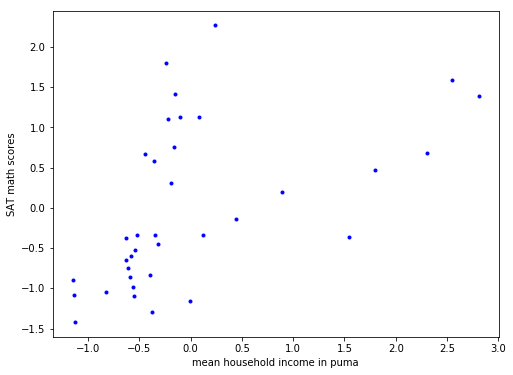

In [119]:
fig, ax = pl.subplots(figsize = (8,6))

ax.plot(demographic_puma_data_std['mean_income'] , demographic_puma_data_std['SATmath'] , 'b.')
pl.ylabel('SAT math scores')
pl.xlabel('mean household income in puma')

print('Covariance : ')
print(str(demographic_puma_data_std[['SATmath' , 'mean_income' ]].cov()))


print(' ')
print('Pearson Correlation Test Result')
print('R-squared : ' + str(sp.stats.pearsonr(demographic_puma_data_std['SATmath'] , demographic_puma_data_std['mean_income'])[0]))

print('P-value : ' + str(sp.stats.pearsonr(demographic_puma_data_std['SATmath'] , demographic_puma_data_std['mean_income'])[1]))



cov_mi_math = smf.ols( formula = 'SATmath ~ mean_income' , data = demographic_puma_data_std).fit()


print('Variable Influence Factor: ' + str(1 /(1 - cov_mi_math.rsquared)))
print('VERDICT : A low VIF around 1-2 is good. The collinearity is very low.')


cov_mi_math.summary()

#### Figure EC3:

The plot shows the scatterplot SAT math score as a function of mean household income at PUMA level.
Graphically, they appear to be related to each other.

It is also mathematically verifed using Pearson's Correlation function giving an r-squared value of about 0.5 with a low p-value although it  is not a reliable measure for small samples.

Covariance : 
               SATall  mean_income
SATall       1.000000     0.590961
mean_income  0.590961     1.000000
 
Pearson Correlation Test Result
R-squared : 0.59096134716
P-value : 0.000147715061424
Variable Influence Factor: 1.53665375713
VERDICT : A low VIF around 1-2 is good. The collinearity is very low.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     18.25
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           0.000148
Time:                        23:09:49   Log-Likelihood:                -42.842
No. Observations:                  36   AIC:                             89.68
Df Residuals:                      34   BIC:                             92.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    -2.22e-16      0.136  -1.63e-15      1.000        -0.277     0.277
mean_income     0.5910      0.138      4.272      0.000         0.310     0.872
==============================================================================
Omnibus:                       11.172   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               10.509
Skew:                           1.236   Prob(JB):                      0.00522
Kurtosis:                       3.946   Cond. No.                         1.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

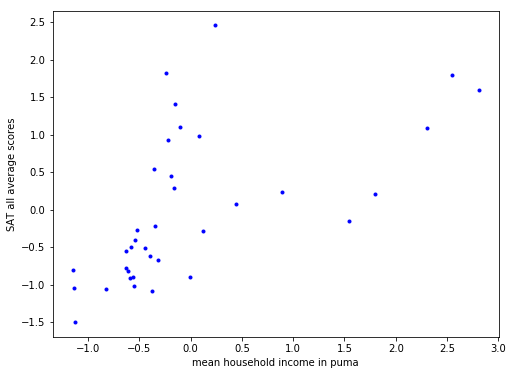

In [120]:
fig, ax = pl.subplots(figsize = (8,6))
ax.plot(demographic_puma_data_std['mean_income'] ,demographic_puma_data_std['SATall'] ,  'b.')

pl.ylabel('SAT all average scores')
pl.xlabel('mean household income in puma')

print('Covariance : ')
print(str(demographic_puma_data_std[['SATall' , 'mean_income' ]].cov()))


print(' ')
print('Pearson Correlation Test Result')
print('R-squared : ' + str(sp.stats.pearsonr(demographic_puma_data_std['SATall'] , demographic_puma_data_std['mean_income'])[0]))

print('P-value : ' + str(sp.stats.pearsonr(demographic_puma_data_std['SATall'] , demographic_puma_data_std['mean_income'])[1]))



cov_mi_all = smf.ols( formula = 'SATall ~ mean_income' , data = demographic_puma_data_std).fit()


print('Variable Influence Factor: ' + str(1 /(1 - cov_mi_all.rsquared)))
print('VERDICT : A low VIF around 1-2 is good. The collinearity is very low.')


cov_mi_all.summary()

#### Figure EC4:

The plot shows the scatterplot SAT average score as a function of mean household income at PUMA level.
Graphically, they appear to be related to each other.

It is also mathematically verifed using Pearson's Correlation function giving an r-squared value of about 0.59 with a low p-value although it  is not a reliable measure for small samples.

# 6 checking collinearity and covariance of the data


### Approach:
1. Plotting the values against each other.
2. Calculating correlattion coefficient
3. Verifying the same using statsmodel OLS
4. Checking for multicollinearity using Variance Inflation Factor
http://blog.minitab.com/blog/starting-out-with-statistical-software/what-in-the-world-is-a-vif

What is multicollinearity? It's simply a term used to describe when two or more predictors in your regression are highly correlated. 

The VIF measures how much the variance of an estimated regression coefficient increases if your predictors are correlated. More variation is bad news; we're looking for precise estimates. If the variance of the coefficients increases, our model isn't going to be as reliable. 


## 6.1 Plot SAT features against each other and assess collinearity

In [141]:
alldata.rename( columns = { 'Major N' : 'MajorN' , \
                          'Oth N' : 'OthN', \
                          'NoCrim N' : 'NoCrimN' , \
                          'Prop N' : 'PropN' , \
                          'Vio N' : 'VioN' , \
                          'AvgOfMajor N' : 'AvgOfMajorN' , \
                          'AvgOfOth N' : 'AvgOfOthN' , \
                          'AvgOfNoCrim N' : 'AvgOfNoCrimN' , \
                          'AvgOfProp N' : 'AvgOfPropN' ,\
                          'AvgOfVio N' : 'AvgOfVioN' } , inplace = True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


Covariance : 
          SATmath    SATall
SATmath  1.000000  0.964542
SATall   0.964542  1.000000
 
Pearson Correlation Test Result
R-squared : 0.964541833736
P-value : 3.00888889384e-21
Variable Influence Factor: 14.355636289
VERDICT: High collinearity between the two variables


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                SATmath   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     454.1
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           3.01e-21
Time:                        23:10:02   Log-Likelihood:                -137.05
No. Observations:                  36   AIC:                             278.1
Df Residuals:                      34   BIC:                             281.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -23.7656     21.113     -1.126      0.268       -66.672    19.141
SATall         1.0868      0.051     21.309      0.000         0.983     1.190
==============================================================================
Omnibus:                       40.527   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.956
Skew:                           2.514   Prob(JB):                     6.11e-34
Kurtosis:                      11.757   Cond. No.                     4.68e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

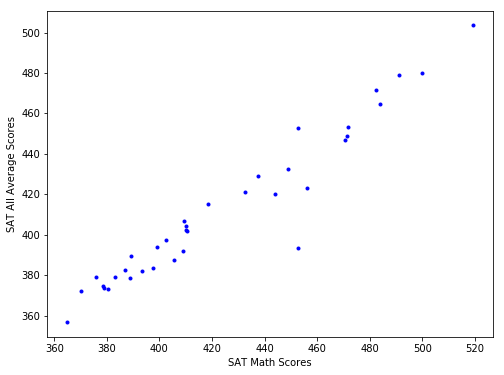

In [122]:
fig, ax = pl.subplots(figsize = (8,6))
ax.plot(alldata['SATmath'] , alldata['SATall'] , 'b.')

pl.xlabel('SAT Math Scores')
pl.ylabel('SAT All Average Scores')

print('Covariance : ')
print(str(independent_params_std[['SATmath' , 'SATall' ]].cov()))


print(' ')
print('Pearson Correlation Test Result')
print('R-squared : ' + str(sp.stats.pearsonr(alldata['SATmath'] , alldata['SATall'])[0]))

print('P-value : ' + str(sp.stats.pearsonr(alldata['SATmath'] , alldata['SATall'])[1]))


cov_sat_math_all = smf.ols( formula = 'SATmath ~ SATall' , data = alldata).fit()


print('Variable Influence Factor: ' + str(1 /(1 - cov_sat_math_all.rsquared)))
print('VERDICT: High collinearity between the two variables')

cov_sat_math_all.summary()

#### Figure 6.1:

The plot shows the scatterplot SAT average score as a function of SAT Maths score at PUMA level.
Graphically, they appear to be highly positively correlated to each other.

It is also mathematically verifed using Pearson's Correlation function giving an r-squared value of almost +1 with an extemely low p-value although it  is not a reliable measure for small samples.

Covariance : 
          SATmath    SATall
SATmath  1.000000  0.964542
SATall   0.964542  1.000000
 
Pearson Correlation Test Result
R-squared : 0.964541833736
P-value : 3.00888889384e-21
Variable Influence Factor: 14.355636289
VERDICT: High collinearity between the two variables


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     454.1
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           3.01e-21
Time:                        23:10:06   Log-Likelihood:                -132.75
No. Observations:                  36   AIC:                             269.5
Df Residuals:                      34   BIC:                             272.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     49.0675     17.128      2.865      0.007        14.259    83.876
SATmath        0.8560      0.040     21.309      0.000         0.774     0.938
==============================================================================
Omnibus:                       38.840   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.340
Skew:                          -2.382   Prob(JB):                     7.48e-32
Kurtosis:                      11.536   Cond. No.                     4.41e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

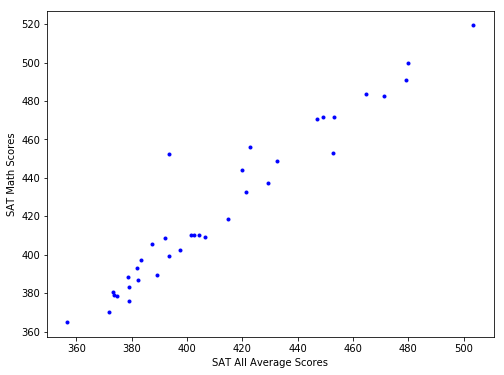

In [123]:
fig, ax = pl.subplots(figsize = (8,6))
ax.plot(alldata['SATall'] , alldata['SATmath'] , 'b.')

pl.ylabel('SAT Math Scores')
pl.xlabel('SAT All Average Scores')

print('Covariance : ')
print(str(independent_params_std[['SATmath' , 'SATall' ]].cov()))


print(' ')
print('Pearson Correlation Test Result')
print('R-squared : ' + str(sp.stats.pearsonr(alldata['SATmath'] , alldata['SATall'])[0]))

print('P-value : ' + str(sp.stats.pearsonr(alldata['SATmath'] , alldata['SATall'])[1]))

cov_sat_math_all = smf.ols( formula = 'SATall ~ SATmath' , data = alldata).fit()


print('Variable Influence Factor: ' + str(1 /(1 - cov_sat_math_all.rsquared)))
print('VERDICT: High collinearity between the two variables')


cov_sat_math_all.summary()

#### Figure 6.2:

The plot shows the scatterplot SAT Maths score as a function of SAT average score  at PUMA level.
Graphically, they appear to be highly positively correlated to each other.

It is also mathematically verifed using Pearson's Correlation function giving an r-squared value of almost +1 with an extemely low p-value although it  is not a reliable measure for small samples.

Judging from the above plots, we can conclude that the various parameters correlate in the same manner for SAT math and SAT average alike

We now drop SAT math and only worry about SAT average, which is highly corrlated to SAT math but likely less noisy cause its an average.

## 6.2 plot the SAT feature by PUMA against 3 of the crime features

Covariance : 
               AvgOfNoCrim N   SATmath
AvgOfNoCrim N       1.000000  0.597446
SATmath             0.597446  1.000000
 
Pearson Correlation Test Result
R-squared : 0.597445752058
P-value : 0.000119494389477
Variable Influence Factor: 1.55506829618
VERDICT : A low VIF around 1 is good. The collinearity is very low.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                SATmath   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     18.87
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           0.000119
Time:                        23:10:13   Log-Likelihood:                -177.06
No. Observations:                  36   AIC:                             358.1
Df Residuals:                      34   BIC:                             361.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept      383.0563     11.076     34.585      0.000       360.547   405.565
AvgOfNoCrimN    11.0632      2.547      4.344      0.000         5.888    16.239
==============================================================================
Omnibus:                        4.416   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                4.001
Skew:                           0.808   Prob(JB):                        0.135
Kurtosis:                       2.763   Cond. No.                         8.82
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

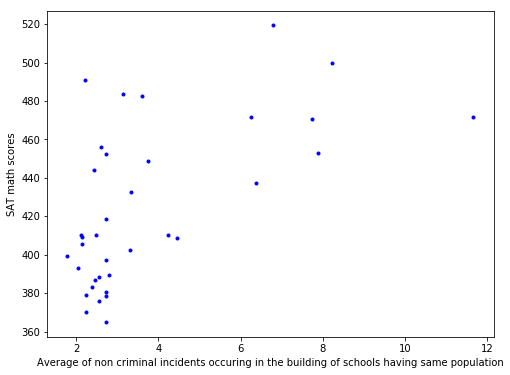

In [124]:
fig, ax = pl.subplots(figsize = (8,6))
ax.plot(alldata['AvgOfNoCrimN'], alldata['SATmath']  ,  'b.')


pl.xlabel('Average of non criminal incidents occuring in the building of schools having same population')
pl.ylabel('SAT math scores')

print('Covariance : ')
print(str(independent_params_std[['AvgOfNoCrim N' , 'SATmath' ]].cov()))

print(' ')
print('Pearson Correlation Test Result')
print('R-squared : ' + str(sp.stats.pearsonr(alldata['AvgOfNoCrimN'] , alldata['SATmath'])[0]))

print('P-value : ' + str(sp.stats.pearsonr(alldata['AvgOfNoCrimN'] , alldata['SATmath'])[1]))


cov_nocrim_sall = smf.ols( formula = 'SATmath ~ AvgOfNoCrimN' , data = alldata).fit()


print('Variable Influence Factor: ' + str(1 /(1 - cov_nocrim_sall.rsquared)))
print('VERDICT : A low VIF around 1 is good. The collinearity is very low.')


cov_nocrim_sall.summary()

#### Figure 
plot of sat math scores against average number of non criminal incidents in school.
low collinearity.
pearson's value shows correlation but p value is an unreliable indicator for small samples

Covariance : 
               AvgOfNoCrim N   SATall
AvgOfNoCrim N        1.00000  0.60922
SATall               0.60922  1.00000
 
Pearson Correlation Test Result
R-squared : 0.609219900726
P-value : 8.03514828661e-05
Variable Influence Factor: 1.59020152788
VERDICT : A low VIF around 1-2 is good. The collinearity is very low.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     20.07
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           8.04e-05
Time:                        23:10:15   Log-Likelihood:                -172.36
No. Observations:                  36   AIC:                             348.7
Df Residuals:                      34   BIC:                             351.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept      374.9511      9.721     38.573      0.000       355.196   394.706
AvgOfNoCrimN    10.0121      2.235      4.480      0.000         5.470    14.554
==============================================================================
Omnibus:                        8.389   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                7.169
Skew:                           1.035   Prob(JB):                       0.0277
Kurtosis:                       3.705   Cond. No.                         8.82
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

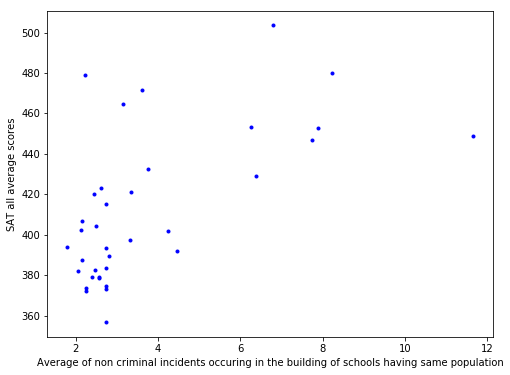

In [125]:
fig, ax = pl.subplots(figsize = (8,6))
ax.plot(alldata['AvgOfNoCrimN'], alldata['SATall']  ,  'b.')


pl.xlabel('Average of non criminal incidents occuring in the building of schools having same population')
pl.ylabel('SAT all average scores')

print('Covariance : ')
print(str(independent_params_std[['AvgOfNoCrim N' , 'SATall' ]].cov()))

print(' ')
print('Pearson Correlation Test Result')
print('R-squared : ' + str(sp.stats.pearsonr(alldata['AvgOfNoCrimN'] , alldata['SATall'])[0]))

print('P-value : ' + str(sp.stats.pearsonr(alldata['AvgOfNoCrimN'] , alldata['SATall'])[1]))


cov_nocrim_sall = smf.ols( formula = 'SATall ~ AvgOfNoCrimN' , data = alldata).fit()


print('Variable Influence Factor: ' + str(1 /(1 - cov_nocrim_sall.rsquared)))
print('VERDICT : A low VIF around 1-2 is good. The collinearity is very low.')


cov_nocrim_sall.summary()

#### Figure 6.3:

The plot shows the scatterplot SAT Average score as a function of Average of non criminal incidents occuring in the building of schools having same population  at PUMA level.
Graphically, they appear to be highly positively correlated to each other.

It is also mathematically verifed using Pearson's Correlation function giving an r-squared value of almost +0.6 with an extemely low p-value although it  is not a reliable measure for small samples.

Covariance : 
              AvgOfMajor N   SATmath
AvgOfMajor N      1.000000  0.664251
SATmath           0.664251  1.000000
 
Pearson Correlation Test Result
R-squared : 0.664250958335
P-value : 9.98772744103e-06
Variable Influence Factor: 1.78964298557
VERDICT : A low VIF around 1-2 is good. The collinearity is very low.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                SATmath   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     26.85
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           9.99e-06
Time:                        23:32:33   Log-Likelihood:                -174.53
No. Observations:                  36   AIC:                             353.1
Df Residuals:                      34   BIC:                             356.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept     396.7670      7.509     52.841      0.000       381.508   412.027
AvgOfMajorN    88.9432     17.166      5.181      0.000        54.059   123.828
==============================================================================
Omnibus:                        4.751   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.093   Jarque-Bera (JB):                4.459
Skew:                           0.843   Prob(JB):                        0.108
Kurtosis:                       2.637   Cond. No.                         3.59
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

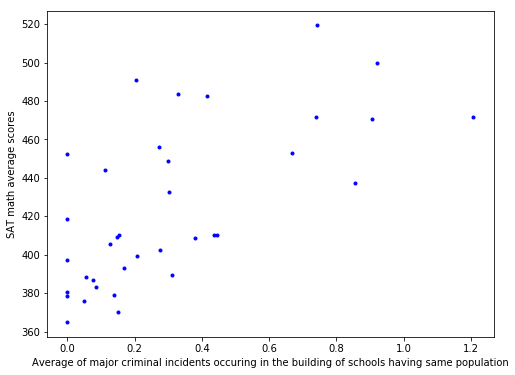

In [190]:
fig, ax = pl.subplots(figsize = (8,6))
ax.plot(alldata['AvgOfMajorN'] , alldata['SATmath'] , 'b.')

pl.xlabel('Average of major criminal incidents occuring in the building of schools having same population')
pl.ylabel('SAT math average scores')


print('Covariance : ')
print(str(independent_params_std[['AvgOfMajor N' , 'SATmath' ]].cov()))


print(' ')
print('Pearson Correlation Test Result')
print('R-squared : ' + str(sp.stats.pearsonr(alldata['AvgOfMajorN'] , alldata['SATmath'])[0]))

print('P-value : ' + str(sp.stats.pearsonr(alldata['AvgOfMajorN'] , alldata['SATmath'])[1]))



cov_nocrim_smath = smf.ols( formula = 'SATmath ~ AvgOfMajorN' , data = alldata).fit()


print('Variable Influence Factor: ' + str(1 /(1 - cov_nocrim_smath.rsquared)))
print('VERDICT : A low VIF around 1-2 is good. The collinearity is very low.')


cov_nocrim_smath.summary()

#### Figure 6.4:

The plot shows the scatterplot SAT Maths score as a function of Average of criminal incidents occuring in the building of schools having same population  at PUMA level.
Graphically, they appear to be highly positively correlated to each other.

It is also mathematically verifed using Pearson's Correlation function giving an r-squared value of almost +0.6 with an extemely low p-value although it  is not a reliable measure for small samples.

Covariance : 
              AvgOfMajor N    SATall
AvgOfMajor N      1.000000  0.696005
SATall            0.696005  1.000000
 
Pearson Correlation Test Result
R-squared : 0.696005141655
P-value : 2.43968794289e-06
Variable Influence Factor: 1.93957508756
VERDICT : A low VIF around 1-2 is good. The collinearity is very low.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     31.95
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           2.44e-06
Time:                        23:10:16   Log-Likelihood:                -168.78
No. Observations:                  36   AIC:                             341.6
Df Residuals:                      34   BIC:                             344.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept     386.6707      6.401     60.406      0.000       373.662   399.679
AvgOfMajorN    82.7103     14.634      5.652      0.000        52.971   112.450
==============================================================================
Omnibus:                        8.692   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                7.625
Skew:                           1.084   Prob(JB):                       0.0221
Kurtosis:                       3.621   Cond. No.                         3.59
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

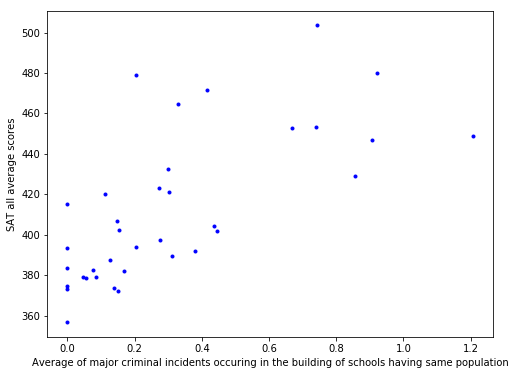

In [127]:
fig, ax = pl.subplots(figsize = (8,6))
ax.plot(alldata['AvgOfMajorN'] , alldata['SATall'] , 'b.')


pl.xlabel('Average of major criminal incidents occuring in the building of schools having same population')
pl.ylabel('SAT all average scores')


print('Covariance : ')
print(str(independent_params_std[['AvgOfMajor N' , 'SATall' ]].cov()))


print(' ')
print('Pearson Correlation Test Result')
print('R-squared : ' + str(sp.stats.pearsonr(alldata['AvgOfMajorN'] , alldata['SATall'])[0]))

print('P-value : ' + str(sp.stats.pearsonr(alldata['AvgOfMajorN'] , alldata['SATall'])[1]))


cov_mcrim_sall = smf.ols( formula = 'SATall ~ AvgOfMajorN' , data = alldata).fit()


print('Variable Influence Factor: ' + str(1 /(1 - cov_mcrim_sall.rsquared)))
print('VERDICT : A low VIF around 1-2 is good. The collinearity is very low.')


cov_mcrim_sall.summary()

#### Figure 6.5:

The plot shows the scatterplot SAT Average score as a function of Average of criminal incidents occuring in the building of schools having same population  at PUMA level.
Graphically, they appear to be highly positively correlated to each other.

It is also mathematically verifed using Pearson's Correlation function giving an r-squared value of almost +0.7 with an extemely low p-value although it  is not a reliable measure for small samples.

Covariance : 
          Major N   SATmath
Major N  1.000000  0.387081
SATmath  0.387081  1.000000
 
Pearson Correlation Test Result
R-squared : 0.387080622257
P-value : 0.0196869519308
Variable Influence Factor: 1.21780064286
VERDICT : A low VIF around 1-2 is good. The collinearity is very low.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     7.405
Date:                Mon, 17 Dec 2018   Prob (F-statistic):             0.0102
Time:                        23:10:17   Log-Likelihood:                -177.16
No. Observations:                  36   AIC:                             358.3
Df Residuals:                      34   BIC:                             361.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    398.2616      7.693     51.770      0.000       382.628   413.895
MajorN        31.1489     11.447      2.721      0.010         7.887    54.411
==============================================================================
Omnibus:                        4.282   Durbin-Watson:                   1.554
Prob(Omnibus):                  0.118   Jarque-Bera (JB):                3.830
Skew:                           0.792   Prob(JB):                        0.147
Kurtosis:                       2.794   Cond. No.                         2.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

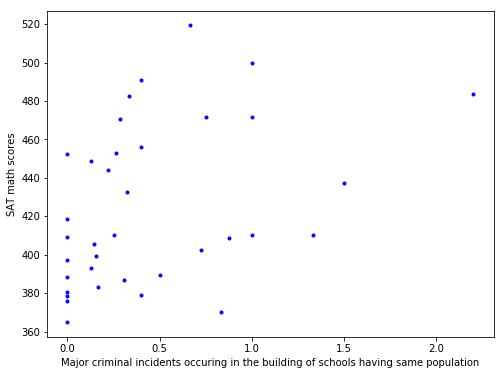

In [128]:
fig, ax = pl.subplots(figsize = (8,6))
ax.plot(alldata['MajorN'] , alldata['SATmath'] , 'b.')

pl.xlabel('Major criminal incidents occuring in the building of schools having same population')
pl.ylabel('SAT math scores')

print('Covariance : ')
print(str(independent_params_std[['Major N' , 'SATmath' ]].cov()))

print(' ')
print('Pearson Correlation Test Result')
print('R-squared : ' + str(sp.stats.pearsonr(alldata['MajorN'] , alldata['SATmath'])[0]))

print('P-value : ' + str(sp.stats.pearsonr(alldata['MajorN'] , alldata['SATmath'])[1]))

cov_mcrim_smath = smf.ols( formula = 'SATall ~ MajorN' , data = alldata).fit()


print('Variable Influence Factor: ' + str(1 /(1 - cov_mcrim_smath.rsquared)))
print('VERDICT : A low VIF around 1-2 is good. The collinearity is very low.')


cov_mcrim_smath.summary()

#### Figure 6.6:

The plot shows the scatterplot SAT Mathematics score as a function of Average of criminal incidents occuring in the building of schools having same population  at PUMA level.
Graphically, they appear to be highly positively correlated to each other.

It is also mathematically verifed using Pearson's Correlation function giving an r-squared value of almost +0.5 with a high low p-value meaning there is a high probability that this result was observed by chance.

Covariance : 
          Major N    SATall
Major N  1.000000  0.422904
SATall   0.422904  1.000000
 
Pearson Correlation Test Result
R-squared : 0.422903694478
P-value : 0.0101783761792
Variable Influence Factor: 1.93957508756
VERDICT : A low VIF around 1-2 is good. The collinearity is very low.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     31.95
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           2.44e-06
Time:                        23:10:19   Log-Likelihood:                -168.78
No. Observations:                  36   AIC:                             341.6
Df Residuals:                      34   BIC:                             344.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept     386.6707      6.401     60.406      0.000       373.662   399.679
AvgOfMajorN    82.7103     14.634      5.652      0.000        52.971   112.450
==============================================================================
Omnibus:                        8.692   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                7.625
Skew:                           1.084   Prob(JB):                       0.0221
Kurtosis:                       3.621   Cond. No.                         3.59
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

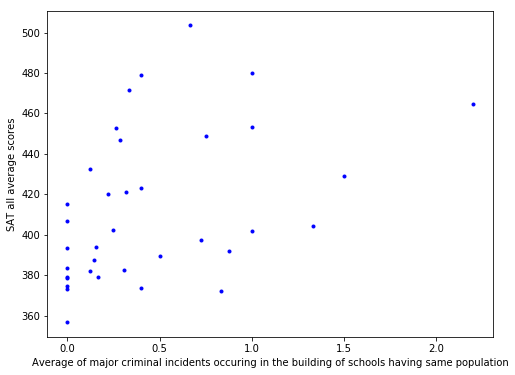

In [129]:

fig, ax = pl.subplots(figsize = (8,6))
ax.plot(alldata['MajorN'] , alldata['SATall'] , 'b.')
pl.xlabel('Average of major criminal incidents occuring in the building of schools having same population')
pl.ylabel('SAT all average scores')

print('Covariance : ')
print(str(independent_params_std[['Major N' , 'SATall' ]].cov()))


print(' ')
print('Pearson Correlation Test Result')
print('R-squared : ' + str(sp.stats.pearsonr(alldata['MajorN'] , alldata['SATall'])[0]))

print('P-value : ' + str(sp.stats.pearsonr(alldata['MajorN'] , alldata['SATall'])[1]))


cov_mcrim_sall = smf.ols( formula = 'SATall ~ AvgOfMajorN' , data = alldata).fit()


print('Variable Influence Factor: ' + str(1 /(1 - cov_mcrim_sall.rsquared)))
print('VERDICT : A low VIF around 1-2 is good. The collinearity is very low.')


cov_mcrim_sall.summary()

#### Figure 6.7:

The plot shows the scatterplot SAT average score as a function of Average of criminal incidents occuring in the building of schools having same population  at PUMA level.
Graphically, they appear to be positively correlated to each other.

It is also mathematically verifed using Pearson's Correlation function giving an r-squared value of almost +0.4 with a low p-value meaning but this result is often an unreliable indicator for sample size < 500

## 6.3 plot the SAT feature against medical data

Covariance : 
            drugsRatio   SATmath
drugsRatio    1.000000 -0.226428
SATmath      -0.226428  1.000000
 
Pearson Correlation Test Result
R-squared : -0.226428262161
P-value : 0.18419569175
Variable Influence Factor: 1.05404039592
VERDICT : A low VIF around 1-2 is good. The collinearity is very low.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                SATmath   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1.837
Date:                Mon, 17 Dec 2018   Prob (F-statistic):              0.184
Time:                        23:10:20   Log-Likelihood:                -184.06
No. Observations:                  36   AIC:                             372.1
Df Residuals:                      34   BIC:                             375.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    432.1946      8.989     48.081      0.000       413.927   450.462
drugsRatio  -159.0414    117.331     -1.355      0.184      -397.486    79.403
==============================================================================
Omnibus:                        3.822   Durbin-Watson:                   1.354
Prob(Omnibus):                  0.148   Jarque-Bera (JB):                2.313
Skew:                           0.402   Prob(JB):                        0.315
Kurtosis:                       2.053   Cond. No.                         17.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

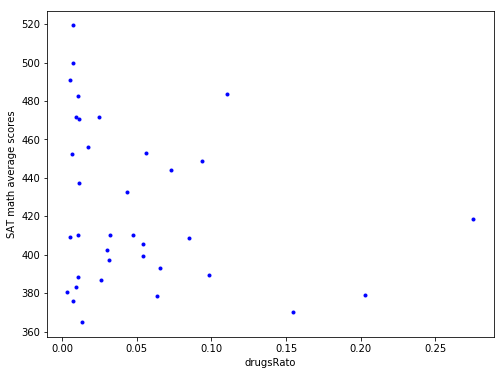

In [130]:
# medical:

fig, ax = pl.subplots(figsize = (8,6))
ax.plot(alldata['drugsRatio'] , alldata['SATmath'] , 'b.')

pl.xlabel('drugsRato')
pl.ylabel('SAT math average scores')

print('Covariance : ')
print(str(independent_params_std[['drugsRatio' , 'SATmath' ]].cov()))


print(' ')
print('Pearson Correlation Test Result')
print('R-squared : ' + str(sp.stats.pearsonr(alldata['drugsRatio'] , alldata['SATmath'])[0]))

print('P-value : ' + str(sp.stats.pearsonr(alldata['drugsRatio'] , alldata['SATmath'])[1]))



cov_drugs_math = smf.ols( formula = 'SATmath ~ drugsRatio' , data = alldata).fit()


print('Variable Influence Factor: ' + str(1 /(1 - cov_drugs_math.rsquared)))
print('VERDICT : A low VIF around 1-2 is good. The collinearity is very low.')


cov_drugs_math.summary()

#### Figure :

The plot shows the scatterplot SAT Mathematics score as a function of drugRatio  at PUMA level.
Graphically, they appear to be  correlated to each other.

It is also mathematically verifed using Pearson's Correlation function giving an r-squared value of almost -0.22 ,ie a low magnitude negative correlation with a high p-value meaning there is a high probability that this result was observed by chance.

Covariance : 
            drugsRatio    SATall
drugsRatio    1.000000 -0.178933
SATall       -0.178933  1.000000
 
Pearson Correlation Test Result
R-squared : -0.178932757794
P-value : 0.296409542808
Variable Influence Factor: 1.03307592133
VERDICT : A low VIF around 1-2 is good. The collinearity is very low.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.125
Date:                Mon, 17 Dec 2018   Prob (F-statistic):              0.296
Time:                        23:10:21   Log-Likelihood:                -180.12
No. Observations:                  36   AIC:                             364.2
Df Residuals:                      34   BIC:                             367.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    417.8282      8.058     51.852      0.000       401.452   434.204
drugsRatio  -111.5413    105.182     -1.060      0.296      -325.296   102.214
==============================================================================
Omnibus:                        3.234   Durbin-Watson:                   1.568
Prob(Omnibus):                  0.199   Jarque-Bera (JB):                2.903
Skew:                           0.622   Prob(JB):                        0.234
Kurtosis:                       2.376   Cond. No.                         17.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

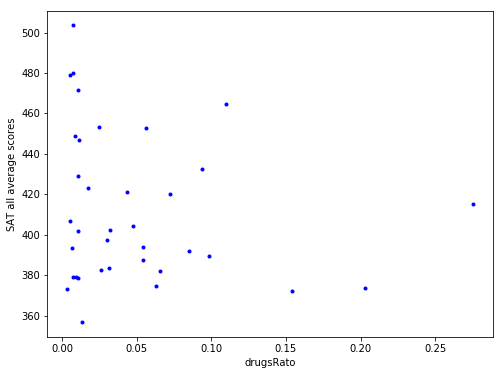

In [131]:
fig, ax = pl.subplots(figsize = (8,6))
ax.plot(alldata['drugsRatio'] , alldata['SATall'] , 'b.')

pl.xlabel('drugsRato')
pl.ylabel('SAT all average scores')

print('Covariance : ')
print(str(independent_params_std[['drugsRatio' , 'SATall' ]].cov()))

print(' ')
print('Pearson Correlation Test Result')
print('R-squared : ' + str(sp.stats.pearsonr(alldata['drugsRatio'] , alldata['SATall'])[0]))

print('P-value : ' + str(sp.stats.pearsonr(alldata['drugsRatio'] , alldata['SATall'])[1]))


cov_drugs_all = smf.ols( formula = 'SATall ~ drugsRatio' , data = alldata).fit()


print('Variable Influence Factor: ' + str(1 /(1 - cov_drugs_all.rsquared)))
print('VERDICT : A low VIF around 1-2 is good. The collinearity is very low.')


cov_drugs_all.summary()

#### Figure 27:

The plot shows the scatterplot SAT Average score as a function of drugRatio  at PUMA level.
Graphically, they appear to be  correlated to each other.

It is also mathematically verifed using Pearson's Correlation function giving an r-squared value of almost -0.17 ,ie a low magnitude negative correlation with a high p-value meaning there is a high probability that this result was observed by chance.

Covariance : 
             asthmaRatio    SATall
asthmaRatio     1.000000 -0.465301
SATall         -0.465301  1.000000
 
Pearson Correlation Test Result
R-squared : -0.465300845373
P-value : 0.00424232998079
Variable Influence Factor: 1.27633213056
VERDICT : A low VIF around 1-2 is good. The collinearity is very low.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     9.395
Date:                Mon, 17 Dec 2018   Prob (F-statistic):            0.00424
Time:                        23:10:22   Log-Likelihood:                -176.32
No. Observations:                  36   AIC:                             356.6
Df Residuals:                      34   BIC:                             359.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept     445.3330     12.114     36.763      0.000       420.715   469.951
asthmaRatio -1088.6215    355.158     -3.065      0.004     -1810.390  -366.853
==============================================================================
Omnibus:                        3.444   Durbin-Watson:                   2.406
Prob(Omnibus):                  0.179   Jarque-Bera (JB):                3.179
Skew:                           0.684   Prob(JB):                        0.204
Kurtosis:                       2.503   Cond. No.                         63.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

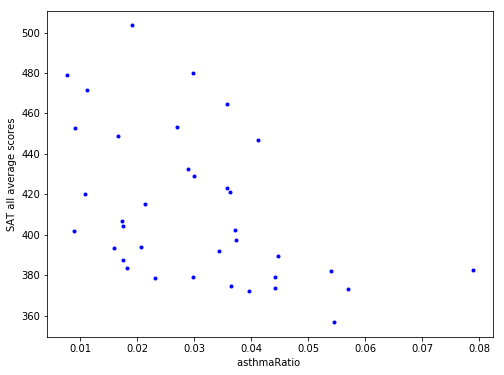

In [132]:
fig, ax = pl.subplots(figsize = (8,6))
ax.plot(alldata['asthmaRatio'] , alldata['SATall'] , 'b.')
pl.xlabel('asthmaRatio ')
pl.ylabel('SAT all average scores')

print('Covariance : ')
print(str(independent_params_std[['asthmaRatio' , 'SATall' ]].cov()))


print(' ')
print('Pearson Correlation Test Result')
print('R-squared : ' + str(sp.stats.pearsonr(alldata['asthmaRatio'] , alldata['SATall'])[0]))

print('P-value : ' + str(sp.stats.pearsonr(alldata['asthmaRatio'] , alldata['SATall'])[1]))


cov_ast_all = smf.ols( formula = 'SATall ~ asthmaRatio' , data = alldata).fit()


print('Variable Influence Factor: ' + str(1 /(1 - cov_ast_all.rsquared)))
print('VERDICT : A low VIF around 1-2 is good. The collinearity is very low.')


cov_ast_all.summary()

#### Figure 28:

The plot shows the scatterplot SAT Mathematics score as a function of asthmaRatio  at PUMA level.
Graphically, they appear to be  correlated to each other.

It is also mathematically verifed using Pearson's Correlation function giving an r-squared value of almost -0.5 ,ie a high magnitude negative correlation with a low p-value , but this value is often an unreliable indicator for small sample with size < 500

Covariance : 
             asthmaRatio   SATmath
asthmaRatio     1.000000 -0.476439
SATmath        -0.476439  1.000000
 
Pearson Correlation Test Result
R-squared : -0.476438834935
P-value : 0.00330869384513
Variable Influence Factor: 1.29365095833
VERDICT : A low VIF around 1-2 is good. The collinearity is very low.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                SATmath   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     9.984
Date:                Mon, 17 Dec 2018   Prob (F-statistic):            0.00331
Time:                        23:10:23   Log-Likelihood:                -180.37
No. Observations:                  36   AIC:                             364.7
Df Residuals:                      34   BIC:                             367.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept     462.4356     13.558     34.109      0.000       434.883   489.988
asthmaRatio -1255.9830    397.492     -3.160      0.003     -2063.784  -448.182
==============================================================================
Omnibus:                        3.265   Durbin-Watson:                   2.186
Prob(Omnibus):                  0.195   Jarque-Bera (JB):                2.862
Skew:                           0.603   Prob(JB):                        0.239
Kurtosis:                       2.327   Cond. No.                         63.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

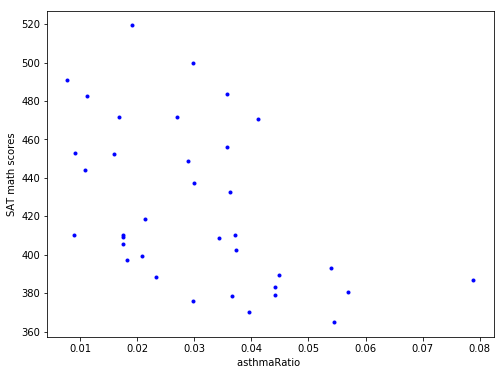

In [133]:
fig, ax = pl.subplots(figsize = (8,6))
ax.plot(alldata['asthmaRatio'] , alldata['SATmath'] , 'b.')
pl.xlabel('asthmaRatio ')
pl.ylabel('SAT math scores')

print('Covariance : ')
print(str(independent_params_std[['asthmaRatio' , 'SATmath' ]].cov()))


print(' ')
print('Pearson Correlation Test Result')
print('R-squared : ' + str(sp.stats.pearsonr(alldata['asthmaRatio'] , alldata['SATmath'])[0]))

print('P-value : ' + str(sp.stats.pearsonr(alldata['asthmaRatio'] , alldata['SATmath'])[1]))


cov_ast_math = smf.ols( formula = 'SATmath ~ asthmaRatio' , data = alldata).fit()


print('Variable Influence Factor: ' + str(1 /(1 - cov_ast_math.rsquared)))
print('VERDICT : A low VIF around 1-2 is good. The collinearity is very low.')


cov_ast_math.summary()

#### Figure 29:

The plot shows the scatterplot SAT overall score as a function of asthmaRatio  at PUMA level.
Graphically, they appear to be  correlated to each other.

It is also mathematically verifed using Pearson's Correlation function giving an r-squared value of almost -0.5 ,ie a high magnitude negative correlation with a low p-value , but this value is often an unreliable indicator for small sample with size < 500

# FBB While all of these are correct, it would have been far more useful to plot them together so you could compare them, you would have noticed that the plots are all basically identical for SAT math and average, and fro all crimes etc. it is a visual representation of what you discovered before, and the correlation is weak so when you say for both figure 6.5 and 6.6 that they are highly corrlated, that is not very meaningful, and not really true: 6.5 is, 6.6 not realluy., at least not when you compare them

### Overall verdict:
All plots above display correlation.
When fitted with a line using OLS, 
they exhibit:
reasonable R-squared, due to which there is low VIF
which means collinearity is less

# FBB 
# task 6 6/10 
while you did everything I asked, and you did write captions, they were not very insightful and did not get to the heard ot the point: the feature space is highly covariant, but weakly correlated with the SAT scores


#  Mapping

(-74.283370477424782,
 -73.672229948940085,
 40.47535029616003,
 40.932182474356594)

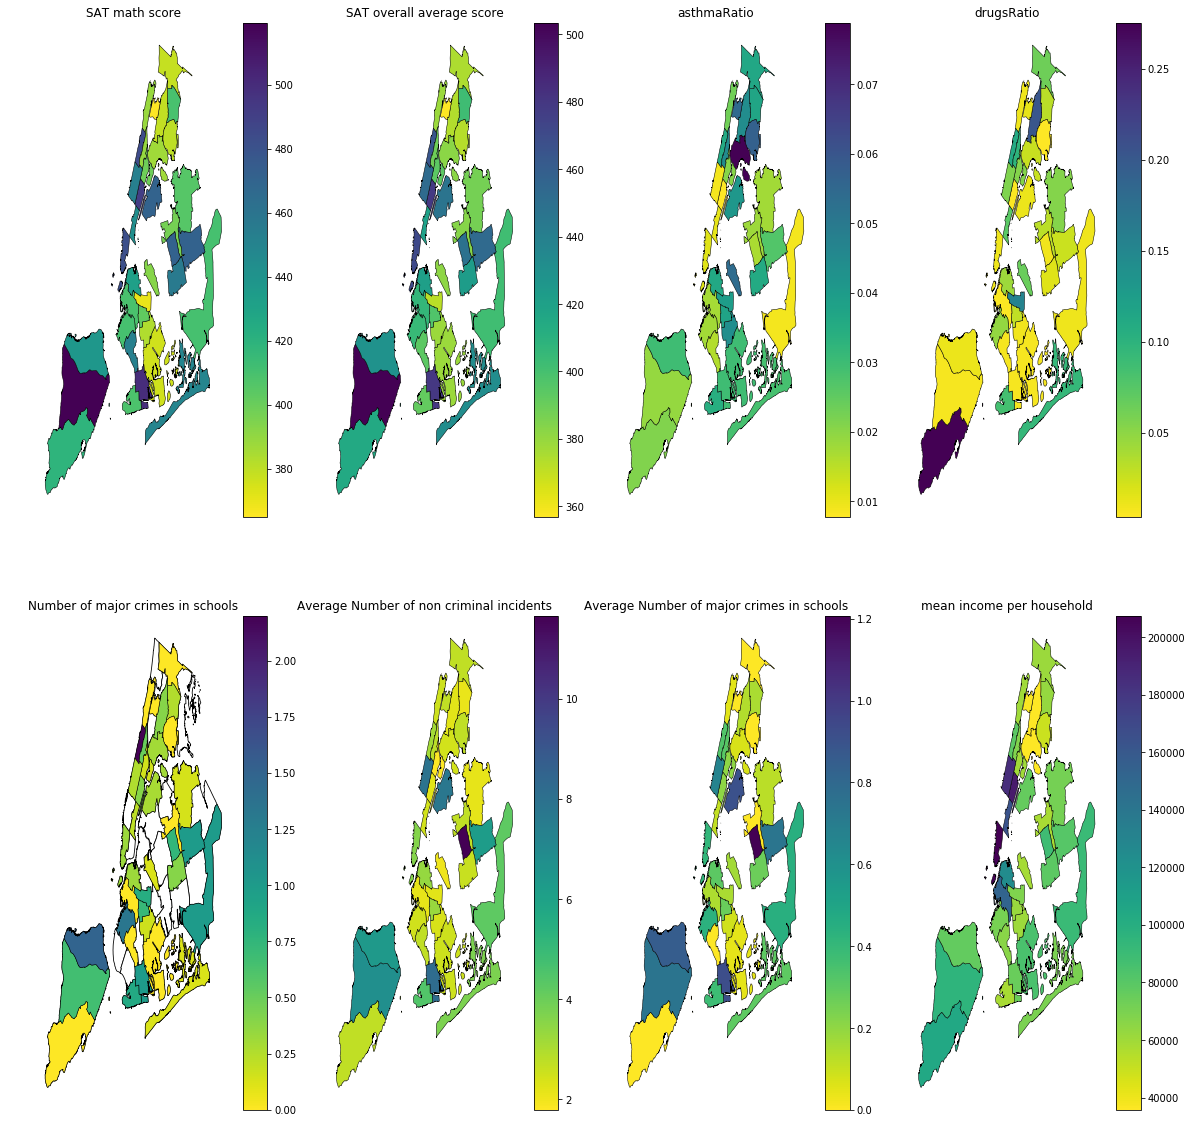

In [136]:
fig = pl.figure(figsize=(20,20))

ax1 = fig.add_subplot(241)

hopital_school_puma_data.plot(column = 'SATmath',linewidth = 0.5, edgecolor = 'Black' ,ax = ax1, cmap = 'viridis_r',legend = True)

pl.title('SAT math score')
pl.axis('off')



ax2 = fig.add_subplot(242)

hopital_school_puma_data.plot(column = 'SATall',linewidth = 0.5, edgecolor = 'Black' ,ax = ax2, cmap = 'viridis_r',legend=True)



pl.title('SAT overall average score')
pl.axis('off')



ax3 = fig.add_subplot(243)

hopital_school_puma_data.plot(column = 'asthmaRatio',linewidth=0.5, edgecolor = 'Black' ,ax = ax3, cmap = 'viridis_r',legend = True)

pl.title('asthmaRatio')
pl.axis('off')



ax4 = fig.add_subplot(244)

hopital_school_puma_data.plot(column = 'drugsRatio',linewidth = 0.5, edgecolor = 'Black' ,ax = ax4, cmap = 'viridis_r',legend = True)
 

pl.title('drugsRatio')
pl.axis('off')



ax5 = fig.add_subplot(245)
puma.plot(linewidth = 0.8, ax = ax5, edgecolor = 'black' , color = 'white')
hopital_school_puma_data.plot(column = 'Major N',linewidth = 0.5, edgecolor = 'Black' ,ax = ax5, cmap = 'viridis_r',legend = True)

pl.title('Number of major crimes in schools')
pl.axis('off')


ax6 = fig.add_subplot(246)

hopital_school_puma_data.plot(column = 'AvgOfNoCrim N',linewidth=0.5, edgecolor = 'Black' ,ax = ax6, cmap = 'viridis_r',legend = True)

pl.title('Average Number of non criminal incidents')
pl.axis('off')

ax7 = fig.add_subplot(247)

hopital_school_puma_data.plot(column = 'AvgOfMajor N',linewidth = 0.5, edgecolor = 'Black' ,ax = ax7, cmap = 'viridis_r',legend = True)
pl.legend()
pl.title('Average Number of major crimes in schools')
pl.axis('off')

ax8 = fig.add_subplot(248)

mean_income_gpd.plot(column = 'mean_income',linewidth = 0.5, edgecolor = 'Black' ,ax = ax8, cmap = 'viridis_r',legend = True)
pl.legend()
pl.title('mean income per household')
pl.axis('off')


### Figure 7.1:
Various parameters observed at PUMA level.
Lighter values represent lower values and darker values represent higher score
* Higher values of the drugsRatio and ashthmaRatio corrrespond to lower SAT scores both Math and Overall
* SAT math score and SAT overall score choropleths look very similar
* Higher mean income in PUMA corresponds to the higher SAT scores.
* There does not appear significant visual correspondance between crime statistics and SAT scores. It can be seen for certain PUMAs but it is not immediately visible

# Lets start with linear modeling 

## 8.1 create a multivariate-linear model using only the crime in school features, but using all 10 of them, predicting the chosen SAT feature

### Standardize the data

In [142]:
alldata_std = alldata.drop('puma' , axis=1)
alldata_std = (alldata_std - alldata_std.mean()) / alldata_std.std()

In [143]:
alldata_std.describe()

,MajorN,OthN,NoCrimN,PropN,VioN,AvgOfMajorN,AvgOfOthN,AvgOfNoCrimN,AvgOfPropN,AvgOfVioN,asthmaRatio,drugsRatio,SATmath,SATall
count,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01
mean,-9.251859e-18,-2.775558e-16,-1.264421e-16,7.709882e-17,6.476301e-17,-3.681469e-17,4.741578e-17,3.151414e-17,1.387779e-17,1.431147e-16,-3.010709e-16,-4.317534e-17,-5.119362e-16,-1.942890e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.964792e-01,-8.774408e-01,-8.129937e-01,-8.777439e-01,-8.494720e-01,-9.930422e-01,-8.394341e-01,-8.585381e-01,-8.562313e-01,-9.282615e-01,-1.421564e+00,-7.634661e-01,-1.418619e+00,-1.494418e+00
25%,-7.105853e-01,-7.040608e-01,-6.265722e-01,-6.992646e-01,-8.027372e-01,-7.271095e-01,-5.830202e-01,-5.755921e-01,-5.847517e-01,-7.568543e-01,-8.075776e-01,-6.548512e-01,-8.434703e-01,-8.109932e-01
50%,-3.081557e-01,-2.802905e-01,-3.133365e-01,-2.845473e-01,-2.739746e-01,-3.397922e-01,-4.316355e-01,-4.461150e-01,-4.451590e-01,-3.695123e-01,-3.398496e-02,-3.511712e-01,-3.384845e-01,-2.783569e-01
75%,5.493621e-01,2.840824e-01,1.697047e-01,2.596357e-01,2.539891e-01,3.502843e-01,1.645310e-01,6.224237e-02,2.479664e-01,2.828310e-01,4.734154e-01,2.463324e-01,6.983086e-01,6.376775e-01
max,3.465831e+00,4.025203e+00,4.319710e+00,3.830394e+00,3.211265e+00,2.869980e+00,3.851058e+00,3.504824e+00,3.894400e+00,2.909689e+00,3.061129e+00,3.796083e+00,2.268771e+00,2.454011e+00


In [144]:
crime_model_all = smf.ols( formula = 'SATall ~ MajorN + OthN  + NoCrimN  + PropN + VioN + AvgOfMajorN +  AvgOfOthN  + AvgOfNoCrimN  + AvgOfPropN + AvgOfVioN' , \
                           data = alldata_std).fit()
crime_model_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     3.301
Date:                Mon, 14 Jan 2019   Prob (F-statistic):            0.00745
Time:                        16:20:05   Log-Likelihood:                -35.424
No. Observations:                  36   AIC:                             92.85
Df Residuals:                      25   BIC:                             110.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept    -1.943e-16      0.129   -1.5e-15      1.000        -0.267     0.267
MajorN           0.7863      0.551      1.428      0.166        -0.348     1.921
OthN             1.2134      1.593      0.761      0.453        -2.068     4.495
NoCrimN          0.3167      0.470      0.673      0.507        -0.652     1.286
PropN           -1.1729      1.116     -1.051      0.303        -3.471     1.125
VioN            -1.1791      0.887     -1.329      0.196        -3.006     0.648
AvgOfMajorN      1.6230      4.115      0.394      0.697        -6.852    10.098
AvgOfOthN        2.6416      6.161      0.429      0.672       -10.048    15.331
AvgOfNoCrimN    -0.8617      1.130     -0.763      0.453        -3.188     1.465
AvgOfPropN      -2.1046      5.201     -0.405      0.689       -12.815     8.606
AvgOfVioN       -0.5912      4.734     -0.125      0.902       -10.342     9.160
==============================================================================
Omnibus:                        4.912   Durbin-Watson:                   1.572
Prob(Omnibus):                  0.086   Jarque-Bera (JB):                3.500
Skew:                           0.700   Prob(JB):                        0.174
Kurtosis:                       3.611   Cond. No.                         199.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpretation of Results:

* R-squared value is 0.569 meaning the model explains about 56.9% of the variance.
* Adjusted R-squared is low meaning it is penalising the large number of parameters.

* The p-values of the parameters are not significant
* ALso the values in confidence intervals are going from positive to negative which dont show a pattern for prediction

* All of the confidence intervals of the parameters have 0 , which means we cannot ignore the effect of 0 or no effect.

* The Cond No is 199 which is indicative of multicollinearity.

## 8.2 add drugs and asthma discharge data and create a new multilinear model

In [145]:
crime_model_all2 = smf.ols( formula = 'SATall ~ MajorN + OthN  + NoCrimN  + PropN + VioN + AvgOfMajorN +  AvgOfOthN  + AvgOfNoCrimN  + AvgOfPropN + AvgOfVioN + asthmaRatio + drugsRatio' , \
                           data = alldata_std).fit()
crime_model_all2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     3.647
Date:                Mon, 14 Jan 2019   Prob (F-statistic):            0.00375
Time:                        16:20:11   Log-Likelihood:                -31.392
No. Observations:                  36   AIC:                             88.78
Df Residuals:                      23   BIC:                             109.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept    -1.943e-16      0.121  -1.61e-15      1.000        -0.250     0.250
MajorN           0.8854      0.531      1.669      0.109        -0.212     1.983
OthN             2.0655      1.545      1.337      0.194        -1.131     5.262
NoCrimN          0.0670      0.455      0.147      0.884        -0.874     1.008
PropN           -1.6079      1.069     -1.504      0.146        -3.820     0.604
VioN            -1.3608      0.842     -1.616      0.120        -3.103     0.381
AvgOfMajorN      1.1037      3.912      0.282      0.780        -6.988     9.195
AvgOfOthN        1.9581      5.805      0.337      0.739       -10.051    13.967
AvgOfNoCrimN    -0.5395      1.070     -0.504      0.619        -2.753     1.674
AvgOfPropN      -1.6879      4.887     -0.345      0.733       -11.798     8.422
AvgOfVioN       -0.2986      4.483     -0.067      0.947        -9.571     8.974
asthmaRatio     -0.3238      0.135     -2.391      0.025        -0.604    -0.044
drugsRatio      -0.0390      0.136     -0.287      0.776        -0.320     0.242
==============================================================================
Omnibus:                        1.667   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.435   Jarque-Bera (JB):                0.978
Skew:                           0.397   Prob(JB):                        0.613
Kurtosis:                       3.152   Cond. No.                         203.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpretation of Results:

* r squared value has increased to explain about 65.6 % of the variance.
* Adjusted r-squared has also increases.
* The parameters such as MajorN, OthN,PropN,and asthmaRatio appear to be relatively more significant in comparision to other parameters.

* asthmaRatio is a good parameter in the sense that its confidence interval values stay in the negative (dont change signs) . So it is a good predictor . A decrease in asthmaratio therefore leads to a increase in the SAT overall score.

* Except asthmaRatio, all of the confidence intervals of the parameters have 0 , Therefore, we cannot reject the null of no or zero effect for these parameters.

* An increase of one standard deviation in asthmaRatio would decrease the SAT score  by a facotr of 1 * -0.03812 = -0.03812

* The Cond No is 186 which is indicative of multicollinearity.



# Lets use the Likelihood Ratio Test to compare the two linear models.



#### Null hypothesis: the parsimonius model is the better model . significance level, alpha =0.05
#### Alternate hypothesis: The model with the higher number of features (the model containing the medical data in parameters) is a better model.

In [146]:
LR_results = crime_model_all2.compare_lr_test(crime_model_all)

In [148]:


if LR_results[1] < 0.05:
    print('Reject the null hypothesis that the restricted model is the better model')
    
    
else:
    print('Fail to reject the null hypothesis that the restricted model is the better model')

print('LR statistic : ' + str(LR_results[0]))
print('P value : ' + str(LR_results[1]))



Reject the null hypothesis that the restricted model is the better model
LR statistic : 8.06392154762
P value : 0.0177395126586


### Interpretation of the LR test results:

Thus the model containing the medical parameters performs better than the model that does not.

Without a more significant investigarion into the domain all you should say here is that we do not see a significant impring of croime in the SAT score, mpossibly because exposure to crime does not affect learning, or because SAT score does not measure learning, or because mitigating factores are in place

In [149]:


demographic_puma_data_std.rename( columns = { 'Major N' : 'MajorN' , \
                          'Oth N' : 'OthN', \
                          'NoCrim N' : 'NoCrimN' , \
                          'Prop N' : 'PropN' , \
                          'Vio N' : 'VioN' , \
                          'AvgOfMajor N' : 'AvgOfMajorN' , \
                          'AvgOfOth N' : 'AvgOfOthN' , \
                          'AvgOfNoCrim N' : 'AvgOfNoCrimN' , \
                          'AvgOfProp N' : 'AvgOfPropN' ,\
                          'AvgOfVio N' : 'AvgOfVioN' } , inplace = True)

demographic_puma_data_std.head()

,MajorN,OthN,NoCrimN,PropN,VioN,AvgOfMajorN,AvgOfOthN,AvgOfNoCrimN,AvgOfPropN,AvgOfVioN,asthmaRatio,drugsRatio,SATmath,SATall,index,mean_income
0,-0.896479,-0.704061,-0.626572,-0.699265,-0.849472,-0.993042,-0.431635,-0.446115,-0.445159,-0.928261,0.390514,0.237457,-1.094745,-1.012331,1.201803,-0.556913
1,-0.400762,0.238521,-0.178066,0.038774,0.386404,-0.502500,-0.709442,-0.714112,-0.697326,-0.533342,0.425111,-0.283537,-0.339480,-0.267264,1.328308,-0.523078
2,-0.103332,0.103633,0.176682,-0.231332,0.209851,-0.545955,-0.671850,-0.663090,-0.686270,-0.554896,0.875731,2.580207,-1.087112,-1.037881,1.391561,-1.139166
3,-0.896479,-0.704061,-0.626572,-0.699265,-0.849472,-0.993042,-0.431635,-0.446115,-0.445159,-0.928261,1.521130,-0.597119,-1.418619,-1.494418,1.518067,-1.129509
4,-0.896479,-0.704061,-0.626572,-0.699265,-0.849472,-0.993042,-0.431635,-0.446115,-0.445159,-0.928261,1.681948,-0.763466,-1.045143,-1.051637,1.644572,-0.827089


In [150]:
demography_model_math = smf.ols( formula = 'SATmath ~ MajorN + OthN  + NoCrimN  + PropN + VioN + AvgOfMajorN +  AvgOfOthN  + AvgOfNoCrimN  + AvgOfPropN + AvgOfVioN + asthmaRatio + drugsRatio + mean_income' , \
                           data = demographic_puma_data_std).fit()
demography_model_math.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                SATmath   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     6.335
Date:                Mon, 14 Jan 2019   Prob (F-statistic):           8.40e-05
Time:                        16:22:37   Log-Likelihood:                -22.553
No. Observations:                  36   AIC:                             73.11
Df Residuals:                      22   BIC:                             95.27
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept    -5.274e-16      0.097  -5.46e-15      1.000        -0.200     0.200
MajorN           1.0176      0.425      2.396      0.026         0.137     1.898
OthN             3.1021      1.244      2.493      0.021         0.522     5.683
NoCrimN         -0.6065      0.378     -1.605      0.123        -1.390     0.177
PropN           -2.0816      0.858     -2.426      0.024        -3.861    -0.302
VioN            -1.5145      0.674     -2.248      0.035        -2.912    -0.117
AvgOfMajorN     -4.9869      3.297     -1.512      0.145       -11.825     1.852
AvgOfOthN        1.2014      4.644      0.259      0.798        -8.430    10.833
AvgOfNoCrimN    -1.2286      0.866     -1.418      0.170        -3.025     0.568
AvgOfPropN      -0.6283      3.912     -0.161      0.874        -8.741     7.485
AvgOfVioN        6.1416      3.752      1.637      0.116        -1.639    13.922
asthmaRatio     -0.0368      0.137     -0.270      0.790        -0.320     0.246
drugsRatio      -0.1279      0.109     -1.178      0.251        -0.353     0.097
mean_income      0.5709      0.147      3.879      0.001         0.266     0.876
==============================================================================
Omnibus:                        5.521   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                4.572
Skew:                           0.868   Prob(JB):                        0.102
Kurtosis:                       3.189   Cond. No.                         205.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpretation of Results:

* R-squared values is 0.789 , which means it explains 78.9% of the variance.
* the mean income becomes the most significant parameter in prediction with a pvalue of 0.001. 
* It has edged out asthmaRatio as a significant model in the precious model. We cannot reject the null for 0 or no effect here 
* Also, various other parameters have gained significance such as: MajorN , OthN , NoCrimN , PropN , VioN
* The intervals of MajorN , OthN are positive meaning an increase in these leads to an increase in the SAT Maths score. 1 std deviation increase leads to an increase in SAT math score by a factor of 1.017 for MajorN and 3.10 for OthN respectively.
* The intervals of  NoCrimN , PropN are negative meaning an increase in these leads to an decrease in the SAT Maths score.1 std deviation increase leads to an decrease in SAT math score by a factor of 0.60 for NoCrimN and 2.08 for PropN respectively

* This is not the case for VioN because the intervals go from negative and positive. So even though the coefficient is negative, it is not a realiable predictor. We cannot reject the null for 0 or no effect for this parameter.
* High condition number is indicative of multicollinearity.

In [151]:
demography_model_all = smf.ols( formula = 'SATall ~ MajorN + OthN  + NoCrimN  + PropN + VioN + AvgOfMajorN +  AvgOfOthN  + AvgOfNoCrimN  + AvgOfPropN + AvgOfVioN + asthmaRatio + drugsRatio + mean_income' , \
                           data = demographic_puma_data_std).fit()
demography_model_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     9.925
Date:                Mon, 14 Jan 2019   Prob (F-statistic):           2.13e-06
Time:                        16:22:38   Log-Likelihood:                -15.900
No. Observations:                  36   AIC:                             59.80
Df Residuals:                      22   BIC:                             81.97
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept    -1.943e-16      0.080  -2.42e-15      1.000        -0.166     0.166
MajorN           0.9677      0.353      2.741      0.012         0.235     1.700
OthN             2.7281      1.034      2.637      0.015         0.583     4.873
NoCrimN         -0.3962      0.314     -1.262      0.220        -1.048     0.255
PropN           -1.9185      0.713     -2.690      0.013        -3.397    -0.440
VioN            -1.3847      0.560     -2.473      0.022        -2.546    -0.223
AvgOfMajorN     -3.6385      2.741     -1.327      0.198        -9.323     2.046
AvgOfOthN        1.5625      3.860      0.405      0.690        -6.444     9.569
AvgOfNoCrimN    -1.1523      0.720     -1.600      0.124        -2.646     0.341
AvgOfPropN      -0.9862      3.252     -0.303      0.765        -7.730     5.758
AvgOfVioN        4.7321      3.119      1.517      0.143        -1.735    11.200
asthmaRatio      0.0552      0.114      0.486      0.632        -0.180     0.291
drugsRatio      -0.0523      0.090     -0.579      0.568        -0.239     0.135
mean_income      0.6703      0.122      5.480      0.000         0.417     0.924
==============================================================================
Omnibus:                        1.772   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.412   Jarque-Bera (JB):                1.587
Skew:                           0.488   Prob(JB):                        0.452
Kurtosis:                       2.678   Cond. No.                         205.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpretation of Results:

* R-squared values is 0.854 , which means it explains 85.4 % of the variance.

* the mean income becomes the most significant parameter in prediction with a pvalue of 0.0000. 

* It has edged out asthmaRatio as a significant model in the precious model. 

* Also, various other parameters have gained significance such as: MajorN , OthN , NoCrimN , PropN , VioN
* The intervals of MajorN , OthN are positive meaning an increase in these leads to an increase in the SAT Maths score.
* The intervals of  NoCrimN , PropN are negative meaning an increase in these leads to an decrease in the SAT Maths score.

* This is not the case for VioN because the intervals go from negative and positive. So even though the coefficient is negative, it is not a realiable predictor.
* condition number indicates high multicollinerity

In [152]:
std_data = (independent_params  - independent_params.mean()) / independent_params.std() 

In [153]:
std_data.columns

Index(['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N', 'AvgOfMajor N',
       'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N',
       'asthmaRatio', 'drugsRatio', 'SATmath', 'SATall'],
      dtype='object')

# Random forest regression on school-related data only 

## I am predicting average SAT score using RF classifiers

# FBB why math? the average score contains math, but should be less noisy as an indicator of learning cause its average

# 10.1 create a random forest model using only the crime in school data, but using all 10 crime in school features

In [150]:
rf_param = std_data[['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N', 'AvgOfMajor N',
       'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N']]
rf_pred = std_data[['SATall']]

In [151]:
features = ['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N', 'AvgOfMajor N',
       'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N']

In [152]:
rf_param_train , rf_param_test , rf_pred_train,rf_pred_test = train_test_split(np.array(rf_param) , np.array(rf_pred) , random_state =1,test_size=0.3)

In [153]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [154]:
rf.fit(rf_param_train, rf_pred_train)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [155]:
rf_prediction = rf.predict(rf_param_test)

In [156]:
errors = abs(rf_prediction.reshape(11,1) - rf_pred_test)

In [158]:
rf.score(rf_param_test, rf_pred_test)




0.03508297971641372

#### Interpretation of Results:
The model has an R-squared value of 0.035 , which means it explains 3.5% of the data

## 10.2 measure the feature importance of the features in this model to select the 3 most predictive features

In [159]:
feature_importance_scores = rf.feature_importances_

In [160]:
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, feature_importance_scores)]

In [161]:
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [162]:
def featureImportancePlot(rf, labels):
    '''plots feature importance for random forest
    rf: the random forest model fit to the data
    labels: the names of the features
    '''
    
    
    importances = rf.feature_importances_
    
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]
    
    

    print(std)
    pl.figure(figsize=(8,8))
    pl.title("Feature importances" ,fontsize=14.0)
    pl.bar(range(indices.shape[0]), rf.feature_importances_[indices],
       color="SteelBlue", yerr=std[indices] , align="center")
    pl.xticks(range(indices.shape[0]), np.array(labels)[indices], rotation=90,fontsize=15.)
    pl.xlim([-1, indices.shape[0]])
    pl.yticks(fontsize=15.)
    pl.show()

[ 0.05549257  0.07159599  0.24075445  0.05381625  0.03975381  0.19878831
  0.25067206  0.24069131  0.2320801   0.30953211]


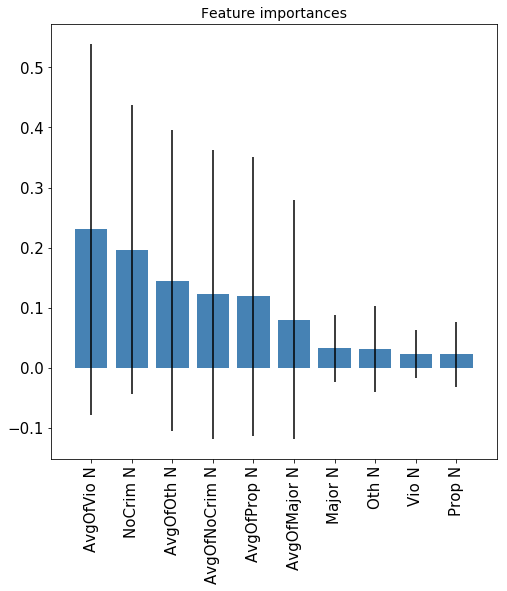

In [163]:
featureImportancePlot(rf,features)

#### Figure :
* The plot shows the importance of the various features.
* The error bars are high indicating that there is a high chance that your model is capturing patterns where it shouldn't and hence giving importance to lesser important feature where it shouldn't.

* Because random forest is a collection of trees,some might capture the correct feature importances, some might not.

* The most importance ones have such a high error rate because in some trees, they may be absolutely ignored altogther or given least importance. While some might capture it correctly



# FBB GOOD!!

In [164]:
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: AvgOfVio N           Importance: 0.23
Variable: NoCrim N             Importance: 0.2
Variable: AvgOfOth N           Importance: 0.14
Variable: AvgOfNoCrim N        Importance: 0.12
Variable: AvgOfProp N          Importance: 0.12
Variable: AvgOfMajor N         Importance: 0.08
Variable: Major N              Importance: 0.03
Variable: Oth N                Importance: 0.03
Variable: Prop N               Importance: 0.02
Variable: Vio N                Importance: 0.02


[None, None, None, None, None, None, None, None, None, None]

#### Interpretation of Results:
The average number of violent incidents in school buildings having the same population seems to be the most important predictor, It is closely followed by the average number of other incidents in school buildings having the same population

# Random forest with crime and medical and income features

In [165]:
std_data.columns

Index(['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N', 'AvgOfMajor N',
       'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N',
       'asthmaRatio', 'drugsRatio', 'SATmath', 'SATall'],
      dtype='object')

## Create a random forest model with  3 most predictive features about school crimes and the health features and income

In [166]:
rf_param2 = std_data[['AvgOfVio N' , 'AvgOfOth N' , 'AvgOfNoCrim N' ,'asthmaRatio' , 'drugsRatio']] 
rf_pred2 = std_data[['SATmath']]

In [167]:
features_2 = rf_param2.columns.tolist()

In [168]:
rf_param_train2 , rf_param_test2 , rf_pred_train2, rf_pred_test2 = train_test_split(np.array(rf_param2) , np.array(rf_pred2) , random_state =1,test_size=0.3)

In [169]:
rf2 = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [170]:
rf2.fit(rf_param_train2, rf_pred_train2)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

## Evaluate the performance of the model

In [171]:
rf2.score(rf_param_test2, rf_pred_test2)

0.40813739680966588

#### Interpretation of Results:
This model has an r-squared of 0.408 , which means it explains about 40.8% of the variance in the data. It has better performance than the earlier model, owing to feature selection by feature importance.

In [172]:
rf_prediction2 = rf2.predict(rf_param_test2)
errors = np.abs(rf_prediction2 - rf_pred_test2)


In [173]:


# Calculate mean absolute percentage error (MAPE)
mape = mean_absolute_error(rf_pred_test2, rf_prediction2)
print('mean_absolute_error : ' + str(mape))         


mean_absolute_error : 0.612914098308


In [174]:


rms = sqrt(mean_squared_error(rf_pred_test2, rf_prediction2))
print('root mean squared error : ' + str(rms))


root mean squared error : 0.717563532035


### Explanation: 
* The model provides an rmse error of 0.717 and a mean absoute error of 0.612. 
* The error rate is high indicating that we need to tune our model further.
* Or maybe it indicates that the parameters are poor predictor of SAT scores.


## 11.3 discuss the importance of each feature in the model

In [175]:
feature_importance_scores2 = rf2.feature_importances_

In [176]:
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_2, feature_importance_scores2)]

In [177]:
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [178]:
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: asthmaRatio          Importance: 0.33
Variable: AvgOfVio N           Importance: 0.24
Variable: AvgOfNoCrim N        Importance: 0.17
Variable: AvgOfOth N           Importance: 0.14
Variable: drugsRatio           Importance: 0.13


[None, None, None, None, None]

[ 0.28995914  0.22951123  0.26390581  0.25162807  0.14231527]


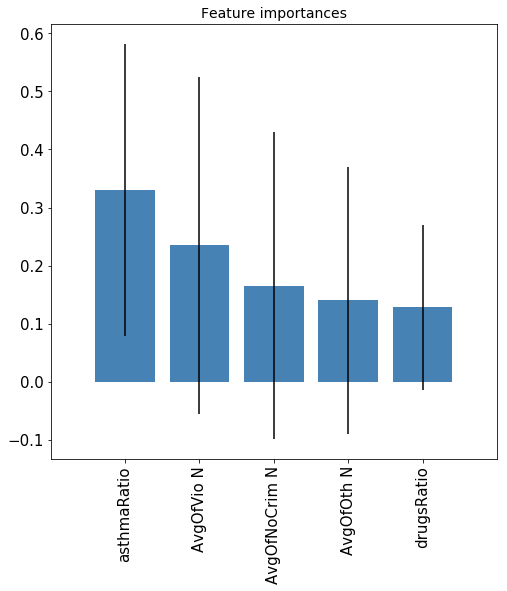

In [179]:
featureImportancePlot(rf2,features_2)

#### Figure :

* The plot shows the importance of the various features of the second model which facotred in the features selected from the first model.
* The error bars are high indicating that there is a high chance that your model is capturing patterns where it shouldn't and hence giving importance to lesser important feature where it shouldn't.

* Because random forest is a collection of trees,some might capture the correct feature importances, some might not.

* The most importance ones have such a high error rate because in some trees, they may be absolutely ignored altogther or given least importance. While some might capture it correctly

* For the case of AsthmaRatio, it is seen as an important predictor, the error bars is not negative which means ,almost all trees realise its importance and dont ignore it.



* AsthmaRatio is the most important predictor of the SAT maths score values. Clearly the living conditions of the students are an important determiner in predicting their performance.

* This is followed by the Avg number of violence incidence in school , average number of non criminal and average number of other incidents. The environment at the school does impact the average sat score of a given school .

* drugsRatio has the least impact ,ie , it does not impact the average SAT score of the given school because not all students do drugs. It would impact the performace only if a predominant population of the student Community was participating in substance abuse. So it has the least impact relatively.




In [180]:
rfparam3 = demographic_puma_data_std[['AvgOfVioN' , 'AvgOfOthN' , 'AvgOfNoCrimN' ,'asthmaRatio' , 'drugsRatio' ,'mean_income']] 
rfpred3 = demographic_puma_data_std[['SATmath']]

In [181]:
features_3 = rfparam3.columns.tolist()

In [182]:
rfparam_train3 , rfparam_test3 , rfpred_train3, rfpred_test3 = train_test_split(np.array(rfparam3) , np.array(rfpred3) , random_state =1,test_size=0.3)

In [183]:
rf3 = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [184]:
rf3.fit(rfparam_train3, rfpred_train3)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [185]:
rf3.score(rfparam_test3, rfpred_test3)

0.19210511390861063

#### Interpretation of Result:
This model has an r-squared of 0.19 , which means it explains about 19% of the variance in the data. It has better performance than the earlier model, owing to feature selection by feature importance.

In [186]:
feature_importance_scores3 = rf3.feature_importances_

[ 0.19980018  0.18777407  0.20553279  0.19833538  0.1080288   0.32310769]


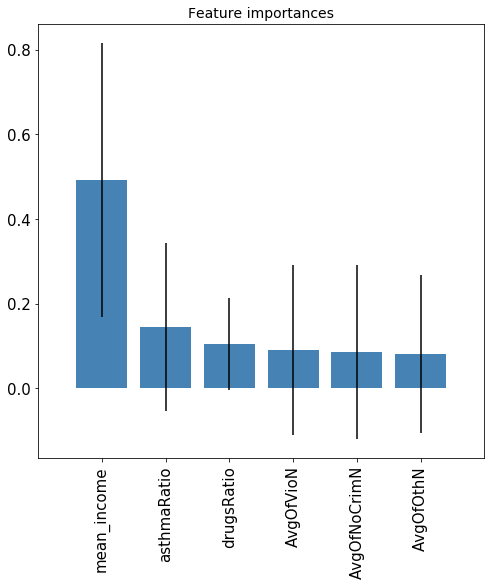

In [187]:
featureImportancePlot(rf3,features_3)

#### Figure Interpretation:
1. mean_income is an important determiner of the SAT score. Children from well off families have the resources and the abiity to perform well.
2. asthmaRatio is the second most important indicator followed by drugsRatio meaning a poor socioeconomic environment is a deterrant to good performance.
3. Incidents of violence in school also hamper performace but not with the impact as big as that of mean income.